## 1. Definición del Problema

### Clasificación de Dirección Diaria de una Acción (AAPL)

**Objetivo:** Predecir si una acción cerrará por encima del precio de apertura en un día bursátil.

**Definición del target:**
* `target_up = 1` si `close > open` (el precio sube durante el día)
* `target_up = 0` si `close <= open` (el precio baja o se mantiene)

---

### ¿Por qué es útil este problema?

Predecir la dirección intradiaria permite:
- Tomar decisiones de entrada/salida el mismo día
- Evitar la complejidad de predecir el precio exacto (clasificación vs regresión)
- Aplicar estrategias de day-trading sistemáticas
- Generar alfa (retorno superior al mercado) si la precisión es >53%

---

### Restricción Crítica: Prevención de Data Leakage

**Solo se pueden usar features disponibles ANTES o EN el momento de la apertura.**

**Features PERMITIDAS:**
- Precios del día anterior: `close_lag1`, `high_lag1`, `low_lag1`
- Indicadores de días pasados: `volatility_5d`, `momentum_3`
- Variables temporales: `day_of_week`, `month`
- Rolling features: `volume_avg_7`, `price_avg_7`

**Features PROHIBIDAS (causan leakage):**
- `close` del día actual (es el target)
- `high` / `low` del día actual (no existen en apertura)
- `return_close_open` del día actual (se calcula al cierre)

---

### Aplicación Práctica: Estrategia de Trading

**Regla simple:**
```
SI modelo predice target_up = 1:
    → Comprar en OPEN
    → Vender en CLOSE
    → Capturar el retorno (close - open) / open

SI modelo predice target_up = 0:
    → Permanecer en efectivo
    → Evitar pérdidas potenciales
```

**Este modelo se utilizará para simular una inversión de USD 10,000 durante el año 2025.**

In [1]:
# LIBRERÍAS BASE
import os
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

warnings.filterwarnings("ignore")

# CONFIGURACIÓN VISUAL
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# SCIKIT-LEARN - PREPROCESAMIENTO
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# SCIKIT-LEARN - MODELOS
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier
)
from sklearn.dummy import DummyClassifier

# BOOSTING EXTERNO
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# MÉTRICAS
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix, 
    classification_report,
    roc_curve, 
    auc
)
# PERSISTENCIA
import joblib

# DISTRIBUCIONES PARA RANDOM SEARCH
import scipy.stats as stats

print("Librerías importadas correctamente")


Librerías importadas correctamente


In [2]:
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB = os.getenv("PG_DB")
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")

TICKER = "AAPL"

pg_url = f"postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DB}"
engine = create_engine(pg_url)

query = """
SELECT
    date,
    ticker,
    year,
    month,
    day_of_week,
    open,
    high,
    low,
    close,
    volume,
    return_close_open,
    return_prev_close,
    volatility_5d,
    close_lag1
FROM analytics.daily_features
WHERE ticker = %s
ORDER BY date ASC;
"""

df = pd.read_sql(query, engine, params=(TICKER,))
df["date"] = pd.to_datetime(df["date"])

print("Filas cargadas:", len(df))
df.head()

# ANÁLISIS DEL DATASET CARGADO

print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)
print(f"Total de registros: {len(df):,}")
print(f"Período: {df['date'].min().date()} a {df['date'].max().date()}")
años_datos = (df['date'].max() - df['date'].min()).days / 365.25
print(f"Años de datos: {años_datos:.2f} años")
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")

if años_datos >= 3:
    print(f"CUMPLE requisito: {años_datos:.1f} años ≥ 3 años mínimos")
else:
    print(f"ADVERTENCIA: Solo {años_datos:.1f} años (mínimo: 3)")

print("\n" + "=" * 60)
print("COLUMNAS DISPONIBLES")
print("=" * 60)
print(df.columns.tolist())

print("\n" + "=" * 60)
print("VALORES NULOS POR COLUMNA")
print("=" * 60)
null_counts = df.isnull().sum()
if null_counts.sum() == 0:
    print("No hay valores nulos en ninguna columna")
else:
    print(null_counts[null_counts > 0])
    print(f"\nTotal de nulos: {null_counts.sum():,}")

print("\n" + "=" * 60)
print("TIPOS DE DATOS")
print("=" * 60)
print(df.dtypes)

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 60)
display(df.describe())

# Verificar todas las columnas están presentes
required_cols = [
    'date', 'ticker', 'year', 'month', 'day_of_week',
    'open', 'high', 'low', 'close', 'volume',
    'return_close_open', 'return_prev_close', 
    'volatility_5d', 'close_lag1'
]

print("\n" + "=" * 60)
print("VERIFICACIÓN DE COLUMNAS REQUERIDAS")
print("=" * 60)
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"FALTAN COLUMNAS: {missing_cols}")
else:
    print("Todas las columnas requeridas están presentes")
    print(f"   → {len(required_cols)} columnas verificadas")

# Mostrar últimas filas para ver el rango completo
print("\n" + "=" * 60)
print("ÚLTIMAS 5 FILAS (verificar período completo)")
print("=" * 60)
display(df.tail())

Filas cargadas: 1989
INFORMACIÓN GENERAL DEL DATASET
Total de registros: 1,989
Período: 2018-01-09 a 2025-12-05
Años de datos: 7.90 años
Dimensiones: 1,989 filas × 14 columnas
CUMPLE requisito: 7.9 años ≥ 3 años mínimos

COLUMNAS DISPONIBLES
['date', 'ticker', 'year', 'month', 'day_of_week', 'open', 'high', 'low', 'close', 'volume', 'return_close_open', 'return_prev_close', 'volatility_5d', 'close_lag1']

VALORES NULOS POR COLUMNA
No hay valores nulos en ninguna columna

TIPOS DE DATOS
date                 datetime64[ns]
ticker                       object
year                          int64
month                         int64
day_of_week                   int64
open                        float64
high                        float64
low                         float64
close                       float64
volume                        int64
return_close_open           float64
return_prev_close           float64
volatility_5d               float64
close_lag1                  float64
dtype

,date,year,month,day_of_week,open,high,low,close,volume,return_close_open,return_prev_close,volatility_5d,close_lag1
count,1989,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000,1989.000000,1989.000000,1989.000000
mean,2021-12-21 18:54:28.778280448,2021.474610,6.512821,2.023630,136.629568,138.156451,135.238952,136.767064,9.488032e+07,0.001084,0.001123,0.016468,136.648817
min,2018-01-09 00:00:00,2018.000000,1.000000,0.000000,35.994999,36.430000,35.500000,35.547501,2.013560e+07,-0.076486,-0.128647,0.000909,35.547501
25%,2019-12-31 00:00:00,2019.000000,4.000000,1.000000,66.449997,67.062500,65.752502,66.592499,5.596280e+07,-0.006577,-0.007983,0.009401,66.572502
50%,2021-12-20 00:00:00,2021.000000,7.000000,2.000000,145.139999,146.970001,143.699997,145.539993,8.137870e+07,0.000942,0.001177,0.013709,145.520004
75%,2023-12-12 00:00:00,2023.000000,9.000000,3.000000,183.419998,185.039993,181.669998,183.630005,1.152304e+08,0.009304,0.011117,0.020443,183.380005
max,2025-12-05 00:00:00,2025.000000,12.000000,4.000000,286.200012,288.619995,283.299988,286.190002,4.265100e+08,0.156441,0.153289,0.107310,286.190002
std,NaN,2.273322,3.399826,1.400253,65.221116,65.876760,64.644465,65.298557,5.447896e+07,0.015090,0.019490,0.010971,65.254198



VERIFICACIÓN DE COLUMNAS REQUERIDAS
Todas las columnas requeridas están presentes
   → 14 columnas verificadas

ÚLTIMAS 5 FILAS (verificar período completo)


,date,ticker,year,month,day_of_week,open,high,low,close,volume,return_close_open,return_prev_close,volatility_5d,close_lag1
1984,2025-12-01,AAPL,2025,12,0,278.010010,283.420013,276.140015,283.100006,46587700,0.018309,0.015241,0.006785,278.850006
1985,2025-12-02,AAPL,2025,12,1,283.000000,287.399994,282.630005,286.190002,53669500,0.011272,0.010915,0.005529,283.100006
1986,2025-12-03,AAPL,2025,12,2,286.200012,288.619995,283.299988,284.149994,43538700,-0.007163,-0.007128,0.008593,286.190002
1987,2025-12-04,AAPL,2025,12,3,284.100006,284.730011,278.589996,280.700012,43989100,-0.011968,-0.012141,0.011671,284.149994
1988,2025-12-05,AAPL,2025,12,4,280.540009,281.140015,278.049988,278.779999,47244000,-0.006274,-0.006840,0.012211,280.700012


## 3. Creación de la Variable Objetivo (Target)

### Importante: Clarificación sobre Data Leakage

**¿Por qué usar `close` y `open` del mismo día NO es leakage?**

Estamos creando el **target** (lo que queremos predecir), no una **feature**.

- **Target (Y):** `close` y `open` del día actual → Lo que predecimos
- **Features (X):** Solo información de días ANTERIORES → Lo que usamos para predecir

**Ejemplo:**
```
Día 2024-01-10:
- Target: close > open del 10 de enero (lo que queremos predecir)
- Features: close_lag1, volatility_5d, etc. del 9 de enero o antes
```

**En producción:**
- En la apertura del día 10, ya sabemos el precio de apertura (open)
- Usamos features de días pasados para predecir si cerrará arriba
- Al cierre verificamos si nuestra predicción fue correcta

--> **No hay leakage porque el target no se usa como feature.**

Inicializando construcción de variable objetivo binaria...

Conteo absoluto de clases:
target_up
Día Verde             1069
Día Rojo o Neutral     920
Name: count, dtype: int64

Proporción relativa:
target_up
Día Verde             0.537456
Día Rojo o Neutral    0.462544
Name: proportion, dtype: float64


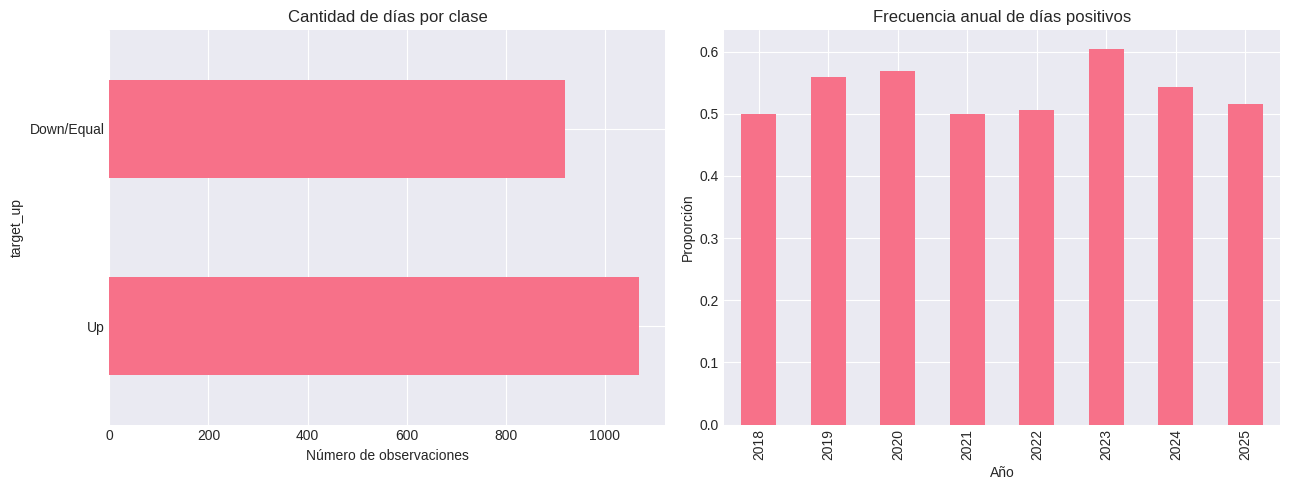


Variable objetivo creada correctamente.
Total de registros: 1,989
Días positivos (target_up=1): 1,069


In [3]:
print("Inicializando construcción de variable objetivo binaria...")
df_model = df.copy()

# Normalización de formato temporal
df_model["date"] = pd.to_datetime(df_model["date"])
df_model = df_model.sort_values("date").reset_index(drop=True)

# VARIABLE OBJETIVO
# 1 = día positivo (close > open)
# 0 = día negativo o neutro
df_model["target_up"] = np.where(
    df_model["close"] > df_model["open"], 1, 0
)

# ANÁLISIS BÁSICO DEL TARGET
conteo = df_model["target_up"].value_counts()
proporcion = df_model["target_up"].value_counts(normalize=True)

print("\nConteo absoluto de clases:")
print(conteo.rename({0: "Día Rojo o Neutral", 1: "Día Verde"}))

print("\nProporción relativa:")
print(proporcion.rename({0: "Día Rojo o Neutral", 1: "Día Verde"}))

# VISUALIZACIÓN 
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

conteo.rename({0: "Down/Equal", 1: "Up"}).plot(
    kind="barh", ax=ax[0]
)
ax[0].set_title("Cantidad de días por clase")
ax[0].set_xlabel("Número de observaciones")

df_model.groupby("year")["target_up"].mean().plot(
    kind="bar", ax=ax[1]
)
ax[1].set_title("Frecuencia anual de días positivos")
ax[1].set_ylabel("Proporción")
ax[1].set_xlabel("Año")

plt.tight_layout()
plt.show()

# Confirmación final
print("\nVariable objetivo creada correctamente.")
print(f"Total de registros: {len(df_model):,}")
print(f"Días positivos (target_up=1): {df_model['target_up'].sum():,}")

In [4]:
# ANÁLISIS PROFUNDO DEL BALANCE Y PATRONES

print("\n" + "=" * 70)
print("ANÁLISIS DE BALANCE DE CLASES")
print("=" * 70)

prop_up = df_model["target_up"].mean()
print(f"Proporción de días UP: {prop_up:.4f} ({prop_up*100:.2f}%)")
print(f"Proporción de días DOWN: {1-prop_up:.4f} ({(1-prop_up)*100:.2f}%)")
print(f"\nBalance: {'EXCELENTE - No requiere balanceo' if 0.45 <= prop_up <= 0.55 else 'Considerar técnicas de balanceo'}")

# Casos edge: close == open
casos_iguales = (df_model["close"] == df_model["open"]).sum()
print(f"\nCasos con close == open (días neutros): {casos_iguales} ({casos_iguales/len(df_model)*100:.2f}%)")

# Análisis por año (para entender años alcistas/bajistas)
print("\n" + "=" * 70)
print("DISTRIBUCIÓN DE DÍAS UP POR AÑO")
print("=" * 70)
year_analysis = df_model.groupby("year").agg({
    'target_up': ['sum', 'count', 'mean']
}).round(4)
year_analysis.columns = ['Días UP', 'Total días', 'Proporción UP']
year_analysis['Tipo de año'] = year_analysis['Proporción UP'].apply(
    lambda x: '🟢 Alcista' if x > 0.55 else ('🔴 Bajista' if x < 0.45 else '⚪ Neutral')
)
print(year_analysis)

# Identificar años extremos
año_mas_alcista = year_analysis['Proporción UP'].idxmax()
año_mas_bajista = year_analysis['Proporción UP'].idxmin()
print(f"\nAño más alcista: {año_mas_alcista} ({year_analysis.loc[año_mas_alcista, 'Proporción UP']:.2%})")
print(f"Año más bajista: {año_mas_bajista} ({year_analysis.loc[año_mas_bajista, 'Proporción UP']:.2%})")

# Análisis por día de la semana
print("\n" + "=" * 70)
print("DISTRIBUCIÓN POR DÍA DE LA SEMANA")
print("=" * 70)
dias_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
dow_analysis = df_model.groupby("day_of_week").agg({
    'target_up': ['sum', 'count', 'mean']
}).round(4)
dow_analysis.columns = ['Días UP', 'Total días', 'Proporción UP']
dow_analysis.index = dow_analysis.index.map(dias_map)
print(dow_analysis)

# ¿Hay patrón de día de semana?
prop_max_dow = dow_analysis['Proporción UP'].max()
prop_min_dow = dow_analysis['Proporción UP'].min()
diferencia_dow = prop_max_dow - prop_min_dow

if diferencia_dow > 0.10:
    print(f"\nPATRÓN DETECTADO: Diferencia de {diferencia_dow:.2%} entre días")
    print(f"   → 'day_of_week' puede ser una feature útil")
else:
    print(f"\nSin patrón fuerte en día de semana (diferencia: {diferencia_dow:.2%})")

# Análisis por mes
print("\n" + "=" * 70)
print("DISTRIBUCIÓN POR MES (Seasonality)")
print("=" * 70)
month_analysis = df_model.groupby("month").agg({
    'target_up': ['sum', 'count', 'mean']
}).round(4)
month_analysis.columns = ['Días UP', 'Total días', 'Proporción UP']
meses = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
         7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'}
month_analysis.index = month_analysis.index.map(meses)
print(month_analysis)

# ¿Hay estacionalidad?
prop_max_month = month_analysis['Proporción UP'].max()
prop_min_month = month_analysis['Proporción UP'].min()
diferencia_month = prop_max_month - prop_min_month

if diferencia_month > 0.15:
    print(f"\nESTACIONALIDAD DETECTADA: Diferencia de {diferencia_month:.2%} entre meses")
    mejor_mes = month_analysis['Proporción UP'].idxmax()
    peor_mes = month_analysis['Proporción UP'].idxmin()
    print(f"   Mejor mes: {mejor_mes} ({month_analysis.loc[mejor_mes, 'Proporción UP']:.2%})")
    print(f"   Peor mes: {peor_mes} ({month_analysis.loc[peor_mes, 'Proporción UP']:.2%})")
else:
    print(f"\n Sin estacionalidad fuerte (diferencia: {diferencia_month:.2%})")


ANÁLISIS DE BALANCE DE CLASES
Proporción de días UP: 0.5375 (53.75%)
Proporción de días DOWN: 0.4625 (46.25%)

Balance: EXCELENTE - No requiere balanceo

Casos con close == open (días neutros): 4 (0.20%)

DISTRIBUCIÓN DE DÍAS UP POR AÑO
      Días UP  Total días  Proporción UP Tipo de año
year                                                
2018      123         246         0.5000   ⚪ Neutral
2019      141         252         0.5595   🟢 Alcista
2020      144         253         0.5692   🟢 Alcista
2021      126         252         0.5000   ⚪ Neutral
2022      127         251         0.5060   ⚪ Neutral
2023      151         250         0.6040   🟢 Alcista
2024      137         252         0.5437   ⚪ Neutral
2025      120         233         0.5150   ⚪ Neutral

Año más alcista: 2023 (60.40%)
Año más bajista: 2018 (50.00%)

DISTRIBUCIÓN POR DÍA DE LA SEMANA
             Días UP  Total días  Proporción UP
day_of_week                                    
Lunes            216         372      

Iniciando Análisis Exploratorio de Datos (EDA)...

Resumen general del dataset:
                                date         year        month  day_of_week  \
count                           1989  1989.000000  1989.000000  1989.000000   
mean   2021-12-21 18:54:28.778280448  2021.474610     6.512821     2.023630   
min              2018-01-09 00:00:00  2018.000000     1.000000     0.000000   
25%              2019-12-31 00:00:00  2019.000000     4.000000     1.000000   
50%              2021-12-20 00:00:00  2021.000000     7.000000     2.000000   
75%              2023-12-12 00:00:00  2023.000000     9.000000     3.000000   
max              2025-12-05 00:00:00  2025.000000    12.000000     4.000000   
std                              NaN     2.273322     3.399826     1.400253   

              open         high          low        close        volume  \
count  1989.000000  1989.000000  1989.000000  1989.000000  1.989000e+03   
mean    136.629568   138.156451   135.238952   136.767064 

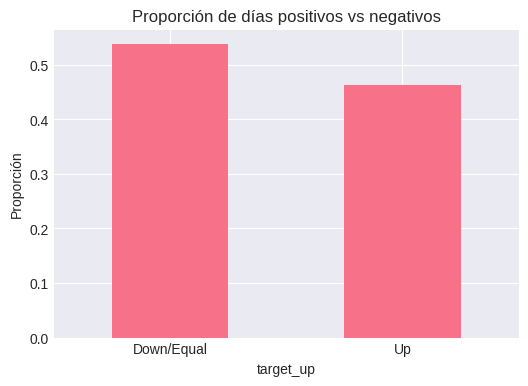

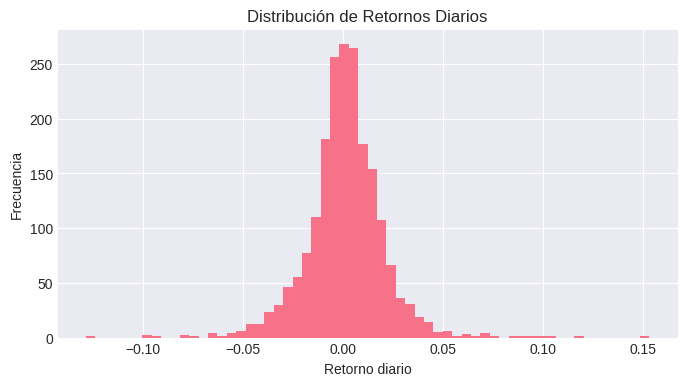

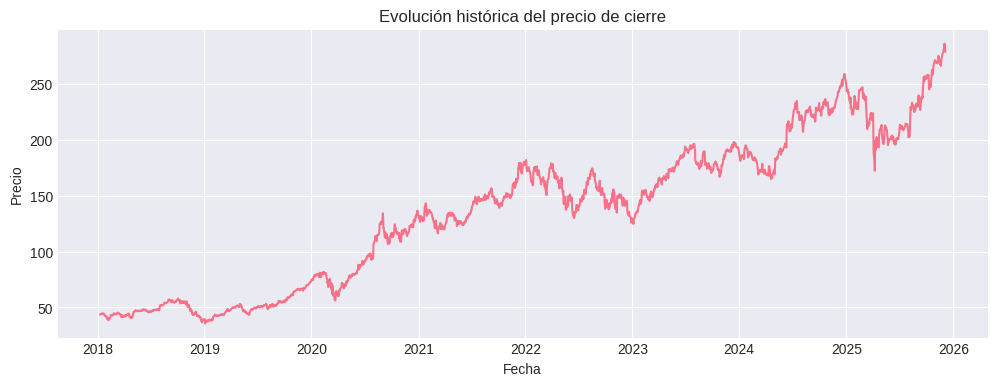

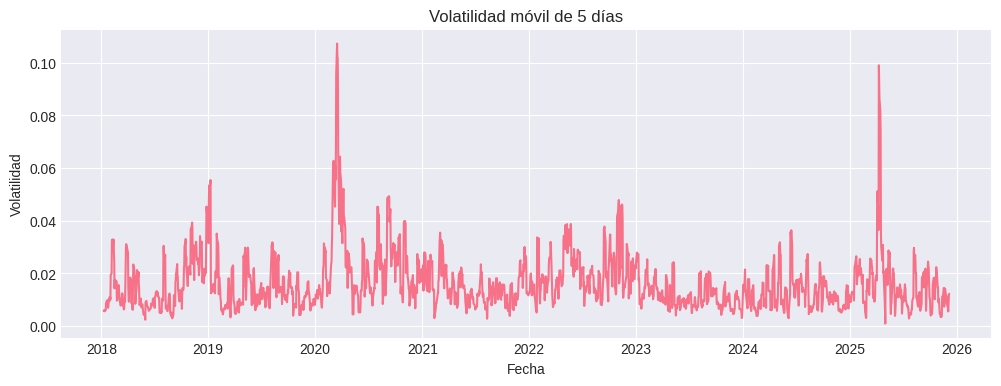


Estadísticas por día de la semana:
             return_prev_close  target_up
day_of_week                              
0                     0.002124   0.580645
1                     0.001646   0.536585
2                     0.002075   0.561576
3                    -0.000327   0.513716
4                     0.000143   0.497500


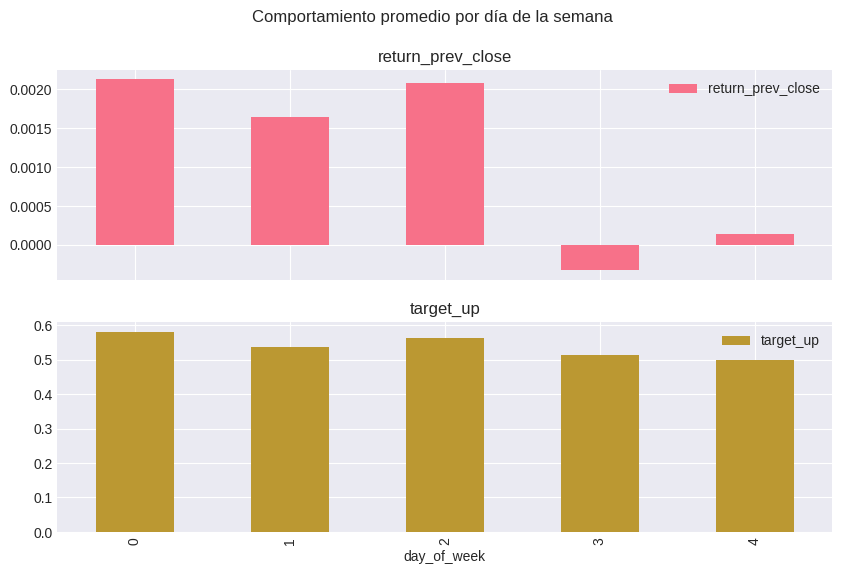

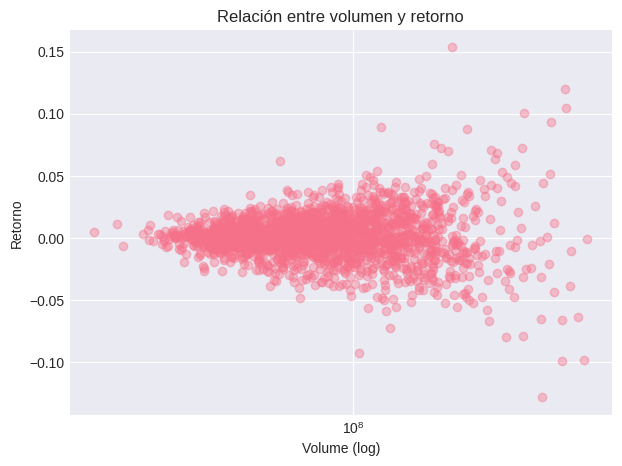

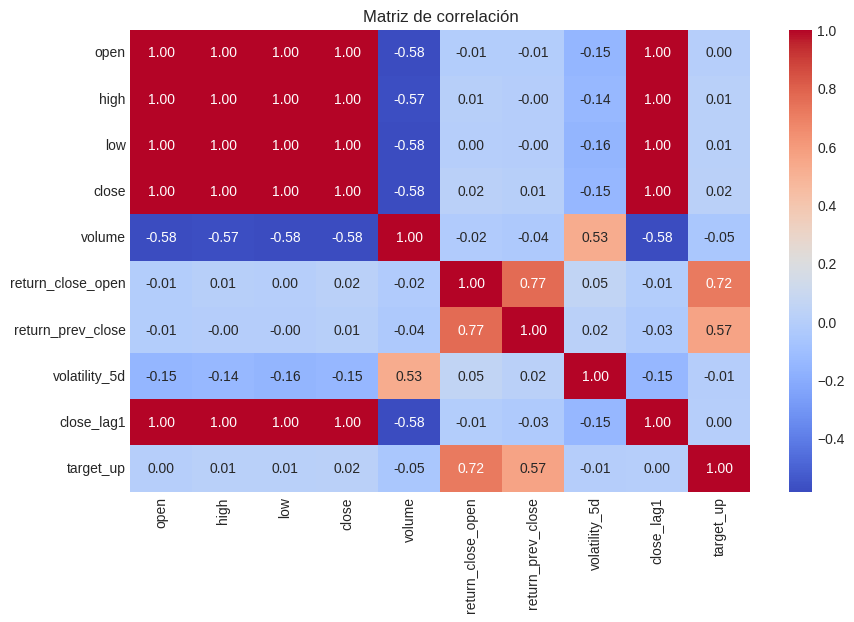

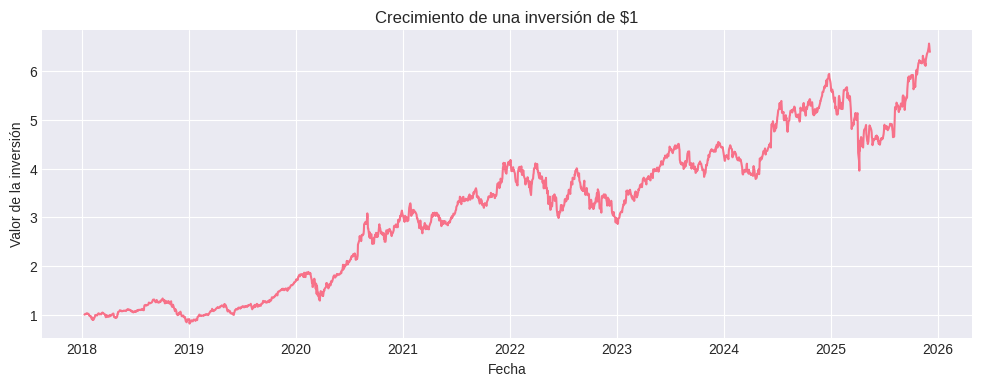

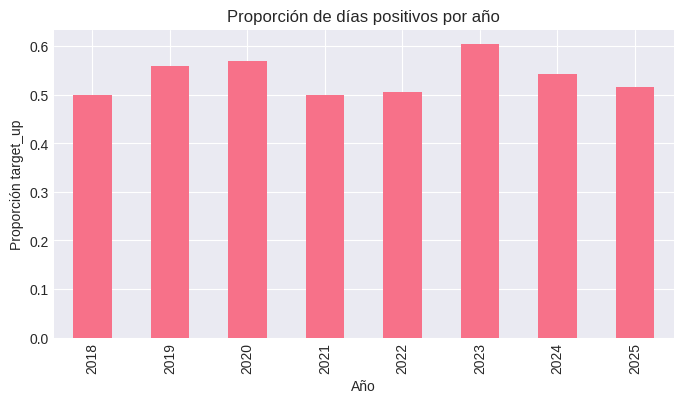


RESUMEN DEL EDA
----------------------------------------
Período analizado: 2018-01-09 → 2025-12-05
Total de observaciones: 1,989
Días positivos: 53.75%
Retorno promedio diario: 0.00112
Volatilidad promedio (5d): 0.01647
Precio promedio: $136.77
Precio máximo: $286.19
Precio mínimo: $35.55


In [5]:
print("Iniciando Análisis Exploratorio de Datos (EDA)...")

df_eda = df_model.copy()

# 1. VISIÓN GENERAL
print("\nResumen general del dataset:")
print(df_eda.describe())

print("\nValores nulos por columna:")
print(df_eda.isnull().sum())

# 2. ANÁLISIS DE LA VARIABLE OBJETIVO
plt.figure(figsize=(6, 4))
df_eda["target_up"].value_counts(normalize=True).plot(kind="bar")
plt.title("Proporción de días positivos vs negativos")
plt.xticks([0, 1], ["Down/Equal", "Up"], rotation=0)
plt.ylabel("Proporción")
plt.show()

# 3. DISTRIBUCIÓN DE RETORNOS
plt.figure(figsize=(8, 4))
plt.hist(df_eda["return_prev_close"], bins=60)
plt.title("Distribución de Retornos Diarios")
plt.xlabel("Retorno diario")
plt.ylabel("Frecuencia")
plt.show()

# 4. EVOLUCIÓN DEL PRECIO DE CIERRE
plt.figure(figsize=(12, 4))
plt.plot(df_eda["date"], df_eda["close"])
plt.title("Evolución histórica del precio de cierre")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.show()

# 5. VOLATILIDAD EN EL TIEMPO
plt.figure(figsize=(12, 4))
plt.plot(df_eda["date"], df_eda["volatility_5d"])
plt.title("Volatilidad móvil de 5 días")
plt.xlabel("Fecha")
plt.ylabel("Volatilidad")
plt.show()


# 6. COMPORTAMIENTO POR DÍA DE LA SEMANA
weekday_stats = df_eda.groupby("day_of_week")[["return_prev_close", "target_up"]].mean()
print("\nEstadísticas por día de la semana:")
print(weekday_stats)

weekday_stats.plot(kind="bar", subplots=True, figsize=(10, 6))
plt.suptitle("Comportamiento promedio por día de la semana")
plt.show()

# 7. VOLUMEN VS RETORNO
plt.figure(figsize=(7, 5))
plt.scatter(df_eda["volume"], df_eda["return_prev_close"], alpha=0.4)
plt.xscale("log")
plt.xlabel("Volume (log)")
plt.ylabel("Retorno")
plt.title("Relación entre volumen y retorno")
plt.show()

# 8. CORRELACIÓN ENTRE VARIABLES
cols_corr = [
    "open", "high", "low", "close", "volume",
    "return_close_open", "return_prev_close",
    "volatility_5d", "close_lag1", "target_up"
]

corr_matrix = df_eda[cols_corr].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

# 9. RETORNO ACUMULADO
df_eda["ret_acum"] = (1 + df_eda["return_prev_close"]).cumprod()

plt.figure(figsize=(12, 4))
plt.plot(df_eda["date"], df_eda["ret_acum"])
plt.title("Crecimiento de una inversión de $1")
plt.xlabel("Fecha")
plt.ylabel("Valor de la inversión")
plt.show()

# 10. COMPORTAMIENTO DEL TARGET POR AÑO
yearly_target = df_eda.groupby("year")["target_up"].mean()

plt.figure(figsize=(8, 4))
yearly_target.plot(kind="bar")
plt.title("Proporción de días positivos por año")
plt.ylabel("Proporción target_up")
plt.xlabel("Año")
plt.show()

print("\nRESUMEN DEL EDA")
print("-" * 40)
print(f"Período analizado: {df_eda['date'].min().date()} → {df_eda['date'].max().date()}")
print(f"Total de observaciones: {len(df_eda):,}")
print(f"Días positivos: {df_eda['target_up'].mean():.2%}")
print(f"Retorno promedio diario: {df_eda['return_prev_close'].mean():.5f}")
print(f"Volatilidad promedio (5d): {df_eda['volatility_5d'].mean():.5f}")
print(f"Precio promedio: ${df_eda['close'].mean():.2f}")
print(f"Precio máximo: ${df_eda['close'].max():.2f}")
print(f"Precio mínimo: ${df_eda['close'].min():.2f}")

## 4. Feature Engineering - Construcción de Variables Predictoras

### Restricción Fundamental: Prevención de Data Leakage

**¿Qué es data leakage?**
Usar información del futuro para predecir el presente. En trading, esto significa usar datos que NO están disponibles en el momento de la apertura.

**Estrategia para evitar leakage:**
- Solo usar información del **día anterior o antes** (lags con `.shift(1)`)
- Rolling features calculados con datos pasados
- Indicadores técnicos que solo usan historia
- NUNCA usar `close`, `high`, `low` del día actual

**Ejemplo de leakage vs no-leakage:**
```python
# LEAKAGE (mal):
df['close'] del día actual → No existe en apertura

# SIN LEAKAGE (bien):
df['close_prev_day'] = df['close'].shift(1) → Disponible en apertura
```

---

### Features Creadas (Justificación)

Nuestras features se dividen en 5 categorías:

#### 1. **Lags de Precios** (5 features)
- `open_prev_day`, `high_prev_day`, `low_prev_day`, `close_prev_day`, `volume_prev_day`
- **Justificación:** Capturan el comportamiento del día anterior
- **Hipótesis:** Si ayer cerró alto, hoy puede continuar la tendencia

#### 2. **Retorno y Volatilidad Pasados** (2 features)
- `ret_prev_day`: Retorno del día anterior
- `volatility_prev_5`: Volatilidad de los últimos 5 días
- **Justificación:** Miden momentum y riesgo reciente
- **Hipótesis:** Alta volatilidad pasada puede indicar continuación o reversión

#### 3. **Rolling Features (Tendencia)** (2 features)
- `volume_avg_7`: Volumen promedio de los últimos 7 días
- `price_avg_7`: Precio promedio de los últimos 7 días
- **Justificación:** Detectan tendencias de corto plazo
- **Hipótesis:** Si el precio está sobre su promedio 7d → tendencia alcista

#### 4. **Momentum (Retornos Acumulados)** (1 feature)
- `momentum_3`: Retorno acumulado últimos 3 días
- **Justificación:** Miden fuerza de la tendencia
- **Hipótesis:** Momentum positivo tiende a continuar (short-term)

#### 5. **Indicadores Técnicos** (2 features)
- `daily_range_prev`: (high - low) / close del día anterior
- `rsi_proxy`: Relative Strength Index (14 días)
- **Justificación:** Detectan sobrecompra/sobreventa
- **Hipótesis:** RSI > 70 → sobrecomprado (posible corrección)

#### 6. **Variables Temporales** (2 features)
- `day_of_week`: 0=Lunes, 4=Viernes
- `month`: 1=Enero, 12=Diciembre
- **Justificación:** Detectan estacionalidad
- **Hipótesis:** Los viernes pueden tener comportamiento diferente (weekend effect)

**Total de features:** 12 features numéricas + 2 temporales = **14 features**

In [6]:
print("Iniciando construcción de variables predictoras...")

df_feat = df_model.copy()
df_feat = df_feat.sort_values(["ticker", "date"]).reset_index(drop=True)

# Trabajo por activo
grp = df_feat.groupby("ticker")

# 1. VARIABLES DESPLAZADAS (LAGS BÁSICOS)
for col in ["open", "high", "low", "close", "volume"]:
    df_feat[f"{col}_prev_day"] = grp[col].shift(1)

df_feat["ret_prev_day"] = grp["return_prev_close"].shift(1)
df_feat["volatility_prev_5"] = grp["volatility_5d"].shift(1)

# 2. MEDIDAS DE TENDENCIA (SOLO LAS MÁS IMPORTANTES)
df_feat["volume_avg_7"] = grp["volume"].shift(1).rolling(7).mean()
df_feat["price_avg_7"]  = grp["close"].shift(1).rolling(7).mean()

# 3. MEDIDA DE RANGO DEL DÍA PREVIO
df_feat["daily_range_prev"] = (
    (df_feat["high_prev_day"] - df_feat["low_prev_day"]) / df_feat["close_prev_day"]
)

# 4. MOMENTUM SIMPLIFICADO (SOLO DOS HORIZONTES)
df_feat["momentum_3"] = grp["close"].shift(1) / grp["close"].shift(4) - 1
df_feat["momentum_7"] = grp["close"].shift(1) / grp["close"].shift(8) - 1

# 5. VOLATILIDAD EXTENDIDA SOLO A 10 DÍAS
df_feat["volatility_10"] = df_feat["ret_prev_day"].rolling(10).std()

# 6. RSI PROXY ROBUSTO
delta = df_feat["close_prev_day"].diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = (-delta.clip(upper=0)).rolling(14).mean()
rs = gain / (loss + 1e-9)
df_feat["rsi_proxy"] = 100 - (100 / (1 + rs))

# 7. LIMPIEZA FINAL
before = len(df_feat)
df_feat = df_feat.dropna().reset_index(drop=True)
after = len(df_feat)

print(f"Filtrado por NaN: {before} → {after} (eliminadas {before - after} filas)")

Iniciando construcción de variables predictoras...
Filtrado por NaN: 1989 → 1974 (eliminadas 15 filas)


In [7]:
print("Preparando matrices de entrada (X) y variable objetivo (y)...")

target_col = "target_up"

numeric_features = [
    "open_prev_day",
    "high_prev_day",
    "low_prev_day",
    "close_prev_day",
    "volume_prev_day",
    "ret_prev_day",
    "volatility_prev_5",
    "volume_avg_7",
    "price_avg_7",
    "daily_range_prev",
    "momentum_3",
    "rsi_proxy"
]

categorical_features = [
    "day_of_week",
    "month"
]

feature_cols = numeric_features + categorical_features

X = df_feat[feature_cols].copy()
y = df_feat[target_col].copy()

print("\nDataset de modelado listo:")
print(f"Observaciones totales: {len(X):,}")
print(f"Features numéricas: {len(numeric_features)}")
print(f"Features categóricas: {len(categorical_features)}")
print(f"Total de features: {len(feature_cols)}")
print(f"Proporción de días positivos (target_up=1): {y.mean():.2%}")

print("\nListado completo de variables predictoras:")
for i, col in enumerate(feature_cols, 1):
    tipo = "Numérica" if col in numeric_features else "Categórica"
    print(f"{i:2d}. {col} → {tipo}")

Preparando matrices de entrada (X) y variable objetivo (y)...

Dataset de modelado listo:
Observaciones totales: 1,974
Features numéricas: 12
Features categóricas: 2
Total de features: 14
Proporción de días positivos (target_up=1): 53.90%

Listado completo de variables predictoras:
 1. open_prev_day → Numérica
 2. high_prev_day → Numérica
 3. low_prev_day → Numérica
 4. close_prev_day → Numérica
 5. volume_prev_day → Numérica
 6. ret_prev_day → Numérica
 7. volatility_prev_5 → Numérica
 8. volume_avg_7 → Numérica
 9. price_avg_7 → Numérica
10. daily_range_prev → Numérica
11. momentum_3 → Numérica
12. rsi_proxy → Numérica
13. day_of_week → Categórica
14. month → Categórica


In [8]:
# VERIFICACIÓN FINAL PRE-MODELADO 

print("\n" + "=" * 70)
print("VERIFICACIONES FINALES ANTES DE MODELADO")
print("=" * 70)

# 1. Verificar que X e y tienen la misma longitud
print(f"\n✓ Dimensiones:")
print(f"  X: {X.shape} (filas × features)")
print(f"  y: {y.shape} (filas,)")

if len(X) == len(y):
    print(f"X e y tienen la misma longitud ({len(X):,} registros)")
else:
    print(f"ERROR: X ({len(X)}) y y ({len(y)}) tienen longitudes diferentes")

# 2. Verificar valores nulos
print(f"\n✓ Valores nulos:")
nulos_X = X.isnull().sum().sum()
nulos_y = y.isnull().sum()
if nulos_X == 0 and nulos_y == 0:
    print(f" No hay valores nulos en X ni en y")
else:
    print(f" X: {nulos_X} nulos, y: {nulos_y} nulos")
    if nulos_X > 0:
        print(f"\n  Nulos por feature:")
        print(X.isnull().sum()[X.isnull().sum() > 0])

# 3. Verificar tipos de datos
print(f"\n✓ Tipos de datos:")
print(X.dtypes)

# 4. Verificar rangos de features (detectar outliers extremos)
print(f"\n✓ Estadísticas de features numéricas:")
print(X[numeric_features].describe())

# 5. Verificar valores infinitos
infinitos = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
if infinitos == 0:
    print(f"\nNo hay valores infinitos")
else:
    print(f"\nHay {infinitos} valores infinitos")

# 6. Balance del target (resumen)
print(f"\n✓ Balance del target:")
print(y.value_counts())
print(f"\n  Proporción UP: {y.mean():.4f} ({y.mean()*100:.2f}%)")
print(f"  Baseline a superar: {max(y.mean(), 1-y.mean()):.4f}")

# 7. Correlación features vs target
print(f"\n✓ Top 5 features más correlacionadas con target:")
X_with_target = X.copy()
X_with_target['target_up'] = y
correlations = X_with_target[numeric_features + ['target_up']].corr()['target_up'].drop('target_up').sort_values(ascending=False)
print(correlations.head())

print("\n" + "=" * 70)
print("DATASET LISTO PARA SPLIT TEMPORAL Y MODELADO")
print("=" * 70)


VERIFICACIONES FINALES ANTES DE MODELADO

✓ Dimensiones:
  X: (1974, 14) (filas × features)
  y: (1974,) (filas,)
X e y tienen la misma longitud (1,974 registros)

✓ Valores nulos:
 No hay valores nulos en X ni en y

✓ Tipos de datos:
open_prev_day        float64
high_prev_day        float64
low_prev_day         float64
close_prev_day       float64
volume_prev_day      float64
ret_prev_day         float64
volatility_prev_5    float64
volume_avg_7         float64
price_avg_7          float64
daily_range_prev     float64
momentum_3           float64
rsi_proxy            float64
day_of_week            int64
month                  int64
dtype: object

✓ Estadísticas de features numéricas:
       open_prev_day  high_prev_day  low_prev_day  close_prev_day  \
count    1974.000000    1974.000000   1974.000000     1974.000000   
mean      137.214241     138.750760    135.817021      137.354458   
std        64.917579      65.569117     64.345342       64.995538   
min        35.994999      36.

In [9]:
print("Iniciando partición temporal de los datos para entrenamiento y evaluación...")

# Asegurar año entero
df_feat["year"] = df_feat["year"].astype(int)

# DEFINICIÓN DE PERÍODOS
train_years = [y for y in df_feat["year"].unique() if y <= 2023]
val_years   = [2024]
test_years  = [2025]

# MÁSCARAS TEMPORALES
mask_train = df_feat["year"].isin(train_years)
mask_val   = df_feat["year"].isin(val_years)
mask_test  = df_feat["year"].isin(test_years)

# APLICACIÓN DEL SPLIT
X_train, y_train = X.loc[mask_train], y.loc[mask_train]
X_val,   y_val   = X.loc[mask_val],   y.loc[mask_val]
X_test,  y_test  = X.loc[mask_test],  y.loc[mask_test]

# LOGS DE CONTROL
print("\nDivisión temporal aplicada:")
print(f"• Años usados para Train: {sorted(train_years)} → {len(X_train):,} registros")
print(f"• Año usado para Val    : {val_years} → {len(X_val):,} registros")
print(f"• Año usado para Test   : {test_years} → {len(X_test):,} registros")

# VERIFICACIÓN DE NO SOLAPAMIENTO
train_range = (df_feat.loc[mask_train, "date"].min(), df_feat.loc[mask_train, "date"].max())
val_range   = (df_feat.loc[mask_val, "date"].min(),   df_feat.loc[mask_val, "date"].max())
test_range  = (df_feat.loc[mask_test, "date"].min(),  df_feat.loc[mask_test, "date"].max())

print("\nRangos temporales verificados:")
print(f"• Train: {train_range[0].date()} → {train_range[1].date()}")
print(f"• Val  : {val_range[0].date()} → {val_range[1].date()}")
print(f"• Test : {test_range[0].date()} → {test_range[1].date()}")

# CONTROL FINAL
print("\nTamaños finales de los datasets:")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val  : X={X_val.shape}, y={y_val.shape}")
print(f"Test : X={X_test.shape}, y={y_test.shape}")

assert train_range[1] < val_range[0], "ERROR: Solapamiento entre Train y Val"
assert val_range[1] < test_range[0],  "ERROR: Solapamiento entre Val y Test"

print("\nSplit temporal correcto y sin data leakage confirmado.")

Iniciando partición temporal de los datos para entrenamiento y evaluación...

División temporal aplicada:
• Años usados para Train: [2018, 2019, 2020, 2021, 2022, 2023] → 1,489 registros
• Año usado para Val    : [2024] → 252 registros
• Año usado para Test   : [2025] → 233 registros

Rangos temporales verificados:
• Train: 2018-01-31 → 2023-12-29
• Val  : 2024-01-02 → 2024-12-31
• Test : 2025-01-02 → 2025-12-05

Tamaños finales de los datasets:
Train: X=(1489, 14), y=(1489,)
Val  : X=(252, 14), y=(252,)
Test : X=(233, 14), y=(233,)

Split temporal correcto y sin data leakage confirmado.


In [10]:
print("Inicializando sistema de transformación de variables para el pipeline de ML...")

# TRANSFORMACIÓN DE VARIABLES NUMÉRICAS
numeric_pipe = Pipeline(
    steps=[
        ("scaling", StandardScaler())
    ]
)

# TRANSFORMACIÓN DE VARIABLES CATEGÓRICAS
categorical_pipe = Pipeline(
    steps=[
        ("encoding", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)

# ENSAMBLE DEL PREPROCESADOR
preprocessor = ColumnTransformer(
    remainder="drop",
    transformers=[
        ("num_block", numeric_pipe, numeric_features),
        ("cat_block", categorical_pipe, categorical_features)
    ]
)

print("\nConfiguración del preprocesador completada:")
print(f"• Variables numéricas: {len(numeric_features)}")
print(f"• Variables categóricas: {len(categorical_features)}")
print(f"• Total de variables de entrada: {len(feature_cols)}")

# AJUSTE SOLO CON TRAIN (ANTI-LEAKAGE)
print("\nAjustando preprocesador únicamente con datos de entrenamiento...")

preprocessor.fit(X_train)

# VERIFICACIÓN DE DIMENSIONES
num_out = len(numeric_features)

cat_encoder = preprocessor.named_transformers_["cat_block"]["encoding"]
cat_out = len(cat_encoder.get_feature_names_out(categorical_features))

print("\nResultado del preprocesamiento:")
print(f"• Features numéricas escaladas: {num_out}")
print(f"• Features categóricas codificadas: {cat_out}")
print(f"• Total final de columnas de entrada al modelo: {num_out + cat_out}")


Inicializando sistema de transformación de variables para el pipeline de ML...

Configuración del preprocesador completada:
• Variables numéricas: 12
• Variables categóricas: 2
• Total de variables de entrada: 14

Ajustando preprocesador únicamente con datos de entrenamiento...

Resultado del preprocesamiento:
• Features numéricas escaladas: 12
• Features categóricas codificadas: 17
• Total final de columnas de entrada al modelo: 29


In [11]:
print("Entrenando modelo de referencia (baseline estadístico)...")

# DEFINICIÓN DEL MODELO BASE
baseline_model = DummyClassifier(strategy="most_frequent", random_state=42)

baseline_pipeline = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("clf", baseline_model)
    ]
)

# AJUSTE SOLO CON TRAIN
baseline_pipeline.fit(X_train, y_train)

# EVALUACIÓN EN VALIDACIÓN
y_val_pred_base = baseline_pipeline.predict(X_val)

acc_base = accuracy_score(y_val, y_val_pred_base)
f1_base = f1_score(y_val, y_val_pred_base)

# LOGS DE RESULTADOS
clase_dominante = "UP" if y_train.mean() > 0.5 else "DOWN / EQUAL"

print("\nResultados del modelo baseline sobre Validation:")
print(f"• Clase que siempre predice: {clase_dominante}")
print(f"• Accuracy: {acc_base:.4f}")
print(f"• F1-score: {f1_base:.4f}")

# REGISTRO PARA COMPARACIÓN
results_table = []
results_table.append({
    "modelo": "Baseline estadístico",
    "accuracy_val": acc_base,
    "f1_val": f1_base
})

Entrenando modelo de referencia (baseline estadístico)...

Resultados del modelo baseline sobre Validation:
• Clase que siempre predice: UP
• Accuracy: 0.5437
• F1-score: 0.7044


In [12]:
import xgboost as xgb  
print("Inicializando colección de modelos de clasificación para optimización...")

model_bank = []

# 1) LOGISTIC REGRESSION
model_bank.append((
    "LogisticRegression",
    LogisticRegression(max_iter=3000, random_state=42),
    {
        "clf__C": stats.loguniform(1e-3, 1e2),
        "clf__class_weight": [None, "balanced"]
    }
))

# 2) LINEAR SVC
model_bank.append((
    "LinearSVC",
    LinearSVC(dual="auto", max_iter=5000, random_state=42),
    {
        "clf__C": stats.loguniform(1e-3, 1e2)
    }
))

# 3) RANDOM FOREST
model_bank.append((
    "RandomForest",
    RandomForestClassifier(n_jobs=-1, random_state=42),
    {
        "clf__n_estimators": stats.randint(150, 500),
        "clf__max_depth": stats.randint(5, 25),
        "clf__min_samples_leaf": stats.randint(1, 10)
    }
))

# 4) GRADIENT BOOSTING
model_bank.append((
    "GradientBoosting",
    GradientBoostingClassifier(random_state=42),
    {
        "clf__n_estimators": stats.randint(80, 250),
        "clf__learning_rate": stats.uniform(0.01, 0.2),
        "clf__max_depth": stats.randint(2, 6)
    }
))

# 5) DECISION TREE 
model_bank.append((
    "DecisionTree",
    DecisionTreeClassifier(random_state=42),
    {
        "clf__max_depth": stats.randint(3, 20),
        "clf__min_samples_split": stats.randint(2, 20),
        "clf__min_samples_leaf": stats.randint(1, 10),
        "clf__criterion": ["gini", "entropy"]
    }
))


# 6) ADABOOST
model_bank.append((
    "AdaBoost",
    AdaBoostClassifier(random_state=42),
    {
        "clf__n_estimators": stats.randint(50, 250),
        "clf__learning_rate": stats.uniform(0.01, 0.8)
    }
))

# 7) XGBOOST
model_bank.append((
    "XGBoost",
    xgb.XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    ),
    {
        "clf__n_estimators": stats.randint(100, 400),
        "clf__max_depth": stats.randint(3, 10),
        "clf__learning_rate": stats.uniform(0.01, 0.2),
        "clf__subsample": stats.uniform(0.6, 0.4),
        "clf__colsample_bytree": stats.uniform(0.6, 0.4)
    }
))

# 8) CATBOOST
model_bank.append((
    "CatBoost",
    CatBoostClassifier(verbose=0, random_state=42),
    {
        "clf__depth": stats.randint(4, 10),
        "clf__learning_rate": stats.uniform(0.01, 0.2),
        "clf__iterations": stats.randint(200, 600)
    }
))

print(f"Modelos preparados para optimización: {len(model_bank)}")

Inicializando colección de modelos de clasificación para optimización...
Modelos preparados para optimización: 8


In [13]:
print("Definiendo configuración de búsqueda aleatoria de hiperparámetros...")

N_ITER = 25      
N_FOLDS = 3      # Validación cruzada temporal simple

print(f"Configuración:")
print(f"• Iteraciones aleatorias por modelo: {N_ITER}")
print(f"• Folds de validación interna: {N_FOLDS}")
print(f"• Total aproximado de entrenamientos: {len(model_bank) * N_ITER * N_FOLDS}")


Definiendo configuración de búsqueda aleatoria de hiperparámetros...
Configuración:
• Iteraciones aleatorias por modelo: 25
• Folds de validación interna: 3
• Total aproximado de entrenamientos: 600


In [14]:
print("Iniciando control de consistencia temporal en los splits...")

# Extraer fechas por subconjunto
dates_train = df_feat.loc[mask_train, "date"]
dates_val   = df_feat.loc[mask_val, "date"]
dates_test  = df_feat.loc[mask_test, "date"]

# 1. Verificación de orden cronológico interno
train_order_ok = dates_train.equals(dates_train.sort_values())
val_order_ok   = dates_val.equals(dates_val.sort_values())
test_order_ok  = dates_test.equals(dates_test.sort_values())

print("\nORDEN CRONOLOGICO INTERNO:")
print(f"   Train ordenado correctamente : {train_order_ok}")
print(f"   Val ordenado correctamente   : {val_order_ok}")
print(f"   Test ordenado correctamente  : {test_order_ok}")

# 2. Verificación de fronteras temporales
train_end = dates_train.max()
val_start = dates_val.min()
val_end   = dates_val.max()
test_start = dates_test.min()

print("\nFRONTERAS TEMPORALES DETECTADAS:")
print(f"   Ultimo dia Train : {train_end.strftime('%Y-%m-%d')}")
print(f"   Primer dia Val   : {val_start.strftime('%Y-%m-%d')}")
print(f"   Ultimo dia Val   : {val_end.strftime('%Y-%m-%d')}")
print(f"   Primer dia Test  : {test_start.strftime('%Y-%m-%d')}")

# 3. Validacion de separacion estricta
split_ok = (train_end < val_start) and (val_end < test_start)

print("\nRESULTADO FINAL DEL CONTROL TEMPORAL:")
if split_ok:
    print("Separacion temporal correcta. No existe cruce de informacion entre Train, Val y Test.")
else:
    print("Error detectado. Existe solapamiento entre los periodos temporales.")

Iniciando control de consistencia temporal en los splits...

ORDEN CRONOLOGICO INTERNO:
   Train ordenado correctamente : True
   Val ordenado correctamente   : True
   Test ordenado correctamente  : True

FRONTERAS TEMPORALES DETECTADAS:
   Ultimo dia Train : 2023-12-29
   Primer dia Val   : 2024-01-02
   Ultimo dia Val   : 2024-12-31
   Primer dia Test  : 2025-01-02

RESULTADO FINAL DEL CONTROL TEMPORAL:
Separacion temporal correcta. No existe cruce de informacion entre Train, Val y Test.


In [15]:
print("Iniciando entrenamiento de modelos con validacion temporal...")

tscv = TimeSeriesSplit(n_splits=5)
n_iter_search = 50

training_results = []
trained_models = {}

print("Configuracion de validacion:")
print(f"Numero de splits temporales: {tscv.n_splits}")
print("Cada iteracion valida siempre con datos posteriores al entrenamiento")

for model_name, base_model, param_space in model_bank:

    print("\n------------------------------------------------------------")
    print(f"Entrenando modelo: {model_name}")
    print("------------------------------------------------------------")

    # Pipeline del modelo
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", base_model)
    ])

    # Busqueda aleatoria de hiperparametros
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_space,
        n_iter=n_iter_search,
        scoring="f1",
        cv=tscv,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    print("Ejecutando busqueda de hiperparametros...")
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    trained_models[model_name] = best_model

    # ===============================
    # MÉTRICAS DE TRAIN
    # ===============================
    y_train_pred = best_model.predict(X_train)

    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_prec = precision_score(y_train, y_train_pred)
    train_rec = recall_score(y_train, y_train_pred)

    try:
        train_proba = best_model.predict_proba(X_train)[:, 1]
        train_auc = roc_auc_score(y_train, train_proba)
    except:
        train_auc = np.nan

    print("\nResultados en TRAIN:")
    print(f"Accuracy : {train_acc:.4f}")
    print(f"F1-score : {train_f1:.4f}")
    print(f"Precision: {train_prec:.4f}")
    print(f"Recall   : {train_rec:.4f}")
    print(f"ROC-AUC  : {train_auc:.4f}")

    # ===============================
    # MÉTRICAS DE VALIDATION
    # ===============================
    y_val_pred = best_model.predict(X_val)

    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1  = f1_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred)
    val_rec  = recall_score(y_val, y_val_pred)

    try:
        val_proba = best_model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, val_proba)
    except:
        val_auc = np.nan

    print("\nResultados en VALIDATION:")
    print(f"Accuracy : {val_acc:.4f}")
    print(f"F1-score : {val_f1:.4f}")
    print(f"Precision: {val_prec:.4f}")
    print(f"Recall   : {val_rec:.4f}")
    print(f"ROC-AUC  : {val_auc:.4f}")
    print(f"Mejor score CV temporal: {search.best_score_:.4f}")

    # ===============================
    # REGISTRO GLOBAL
    # ===============================
    training_results.append({
        "modelo": model_name,

        # CV temporal:
        "mejor_score_cv": search.best_score_,

        # TRAIN:
        "train_accuracy": train_acc,
        "train_f1": train_f1,
        "train_precision": train_prec,
        "train_recall": train_rec,
        "train_roc_auc": train_auc,

        # VAL:
        "val_accuracy": val_acc,
        "val_f1": val_f1,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_roc_auc": val_auc
    })

print("\nEntrenamiento finalizado correctamente.")
print(f"Total de modelos entrenados: {len(training_results)}")


Iniciando entrenamiento de modelos con validacion temporal...
Configuracion de validacion:
Numero de splits temporales: 5
Cada iteracion valida siempre con datos posteriores al entrenamiento

------------------------------------------------------------
Entrenando modelo: LogisticRegression
------------------------------------------------------------
Ejecutando busqueda de hiperparametros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Resultados en TRAIN:
Accuracy : 0.5426
F1-score : 0.7025
Precision: 0.5425
Recall   : 0.9963
ROC-AUC  : 0.5545

Resultados en VALIDATION:
Accuracy : 0.5437
F1-score : 0.7044
Precision: 0.5437
Recall   : 1.0000
ROC-AUC  : 0.5122
Mejor score CV temporal: 0.6863

------------------------------------------------------------
Entrenando modelo: LinearSVC
------------------------------------------------------------
Ejecutando busqueda de hiperparametros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Resultados en TRAIN:
Accur

In [16]:
results_df = pd.DataFrame(training_results)

results_df = results_df.sort_values(by="val_f1", ascending=False).reset_index(drop=True)

print("Ranking de modelos por F1 en Validation:")
display(results_df)


Ranking de modelos por F1 en Validation:


,modelo,mejor_score_cv,train_accuracy,train_f1,train_precision,train_recall,train_roc_auc,val_accuracy,val_f1,val_precision,val_recall,val_roc_auc
0,LogisticRegression,0.686276,0.542646,0.702490,0.542510,0.996283,0.554474,0.543651,0.704370,0.543651,1.000000,0.512155
1,LinearSVC,0.573314,0.564809,0.679842,0.565325,0.852540,NaN,0.527778,0.657061,0.542857,0.832117,NaN
2,GradientBoosting,0.579523,0.597045,0.720930,0.577066,0.960347,0.663265,0.551587,0.652308,0.563830,0.773723,0.531419
3,AdaBoost,0.523847,0.576226,0.700806,0.567588,0.915737,0.614023,0.543651,0.637224,0.561111,0.737226,0.517772
4,XGBoost,0.543722,0.639355,0.740955,0.606635,0.951673,0.758586,0.527778,0.631579,0.548387,0.744526,0.492352
5,CatBoost,0.514317,0.687710,0.767616,0.643216,0.951673,0.830679,0.500000,0.611111,0.529412,0.722628,0.487147
6,DecisionTree,0.655436,0.574882,0.698428,0.567337,0.908302,0.569234,0.507937,0.578231,0.541401,0.620438,0.521295
7,RandomForest,0.515982,0.667562,0.757472,0.626418,0.957869,0.823391,0.460317,0.451613,0.504505,0.408759,0.460489


In [17]:
best_row = results_df.iloc[0]

best_model_name = best_row["modelo"]
best_val_f1     = best_row["val_f1"]
best_val_acc    = best_row["val_accuracy"]
best_val_prec   = best_row["val_precision"]
best_val_rec    = best_row["val_recall"]
best_val_auc    = best_row["val_roc_auc"]

best_model = trained_models[best_model_name]

In [18]:
best_model_name = results_df.loc[0, "modelo"]
best_model = trained_models[best_model_name]

print("Mejor modelo seleccionado:")
print(best_model_name)


Mejor modelo seleccionado:
LogisticRegression



TABLA COMPARATIVA DE TODOS LOS MODELOS

RESULTADOS EN VALIDACIÓN (ordenados por F1):

                  Modelo CV Score Val Accuracy  Val F1 Val Precision Val Recall Val ROC-AUC
0  Baseline (siempre UP)        -       0.5437  0.7044        0.5437     1.0000      0.5000
1     LogisticRegression   0.6863       0.5437  0.7044        0.5437     1.0000      0.5122
2              LinearSVC   0.5733       0.5278  0.6571        0.5429     0.8321         N/A
3       GradientBoosting   0.5795       0.5516  0.6523        0.5638     0.7737      0.5314
4               AdaBoost   0.5238       0.5437  0.6372        0.5611     0.7372      0.5178
5                XGBoost   0.5437       0.5278  0.6316        0.5484     0.7445      0.4924
6               CatBoost   0.5143       0.5000  0.6111        0.5294     0.7226      0.4871
7           DecisionTree   0.6554       0.5079  0.5782        0.5414     0.6204      0.5213
8           RandomForest   0.5160       0.4603  0.4516        0.5045     0.4088      

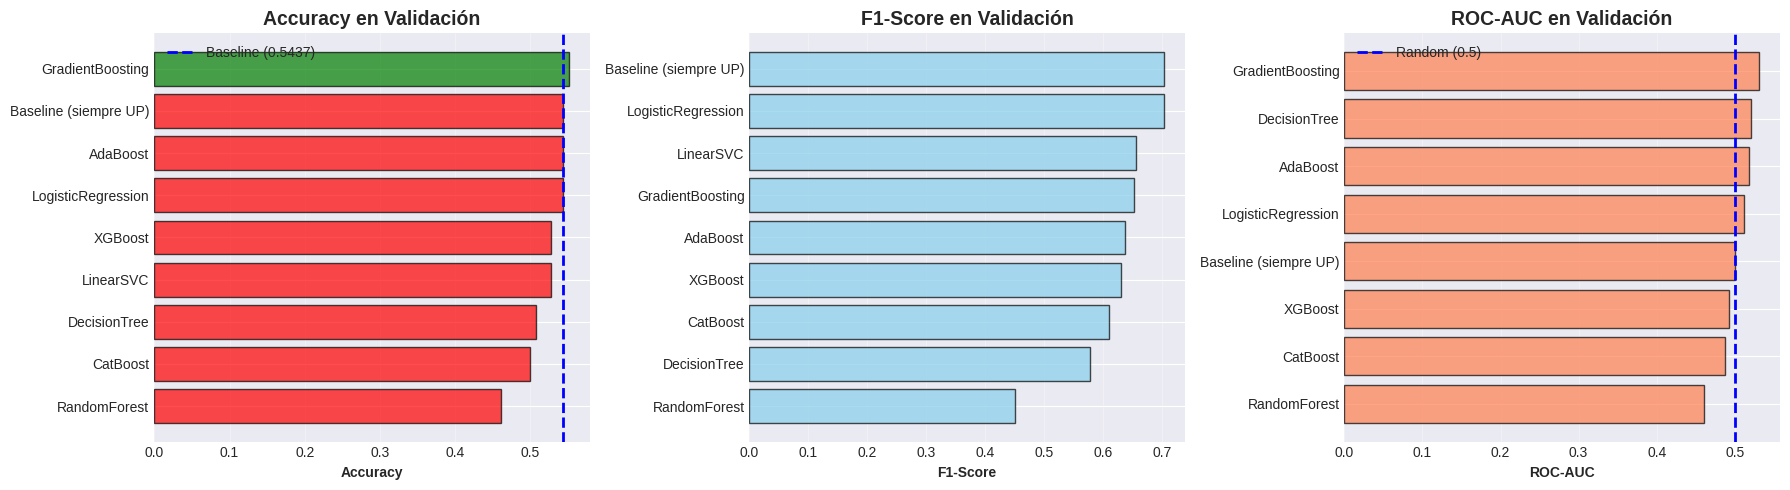

In [22]:
# === TABLA COMPARATIVA DE RESULTADOS ===

print("\n" + "=" * 80)
print("TABLA COMPARATIVA DE TODOS LOS MODELOS")
print("=" * 80)

# Crear DataFrame con los resultados
results_df = pd.DataFrame(training_results)

# Agregar el baseline para comparación
results_df = pd.concat([
    pd.DataFrame([{
        "modelo": "Baseline (siempre UP)",
        "mejor_score_cv": np.nan,
        "val_accuracy": 0.5437,
        "val_f1": 0.7044,
        "val_precision": 0.5437,
        "val_recall": 1.0000,
        "val_roc_auc": 0.5000
    }]),
    results_df
], ignore_index=True)

# Ordenar por F1 en validación (métrica principal)
results_df = results_df.sort_values('val_f1', ascending=False).reset_index(drop=True)

# === PREPARAR TABLA PARA DISPLAY ===

# Nos quedamos solo con las columnas necesarias (7 columnas)
cols_finales = [
    "modelo", "mejor_score_cv", "val_accuracy",
    "val_f1", "val_precision", "val_recall", "val_roc_auc"
]

results_display = results_df[cols_finales].copy()

# Formateo
results_display['mejor_score_cv'] = results_display['mejor_score_cv'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "-")
results_display['val_accuracy'] = results_display['val_accuracy'].apply(lambda x: f"{x:.4f}")
results_display['val_f1'] = results_display['val_f1'].apply(lambda x: f"{x:.4f}")
results_display['val_precision'] = results_display['val_precision'].apply(lambda x: f"{x:.4f}")
results_display['val_recall'] = results_display['val_recall'].apply(lambda x: f"{x:.4f}")
results_display['val_roc_auc'] = results_display['val_roc_auc'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

# Renombrar columnas para mostrar bonito
results_display.columns = [
    'Modelo', 'CV Score', 'Val Accuracy', 'Val F1',
    'Val Precision', 'Val Recall', 'Val ROC-AUC'
]

print("\nRESULTADOS EN VALIDACIÓN (ordenados por F1):\n")
print(results_display.to_string(index=True))

# Identificar el mejor modelo
print("\n" + "=" * 80)
print("ANÁLISIS DE RESULTADOS")
print("=" * 80)

# Mejor por accuracy
best_acc_idx = results_df['val_accuracy'].idxmax()
best_acc_model = results_df.loc[best_acc_idx, 'modelo']
best_acc_value = results_df.loc[best_acc_idx, 'val_accuracy']

# Mejor por F1
best_f1_idx = results_df['val_f1'].idxmax()
best_f1_model = results_df.loc[best_f1_idx, 'modelo']
best_f1_value = results_df.loc[best_f1_idx, 'val_f1']

# Mejor por ROC-AUC
best_auc_idx = results_df['val_roc_auc'].idxmax()
best_auc_model = results_df.loc[best_auc_idx, 'modelo']
best_auc_value = results_df.loc[best_auc_idx, 'val_roc_auc']

print(f"\nMEJOR MODELO POR MÉTRICA:")
print(f"   Accuracy:  {best_acc_model} ({best_acc_value:.4f})")
print(f"   F1-Score:  {best_f1_model} ({best_f1_value:.4f})")
print(f"   ROC-AUC:   {best_auc_model} ({best_auc_value:.4f})")

# Modelos que superan el baseline
baseline_acc = 0.5437
modelos_sobre_baseline = results_df[
    (results_df['modelo'] != 'Baseline (siempre UP)') & 
    (results_df['val_accuracy'] > baseline_acc)
]

print(f"\nMODELOS QUE SUPERAN EL BASELINE (Acc > {baseline_acc:.4f}):")
if len(modelos_sobre_baseline) > 0:
    for _, row in modelos_sobre_baseline.iterrows():
        mejora = (row['val_accuracy'] - baseline_acc) * 100
        print(f"   • {row['modelo']}: {row['val_accuracy']:.4f} (+{mejora:.2f}%)")
else:
    print("   Ningún modelo supera consistentemente al baseline")

# Modelos que NO superan el baseline
modelos_bajo_baseline = results_df[
    (results_df['modelo'] != 'Baseline (siempre UP)') & 
    (results_df['val_accuracy'] <= baseline_acc)
]

print(f"\nMODELOS POR DEBAJO DEL BASELINE:")
for _, row in modelos_bajo_baseline.iterrows():
    diferencia = (row['val_accuracy'] - baseline_acc) * 100
    print(f"   • {row['modelo']}: {row['val_accuracy']:.4f} ({diferencia:.2f}%)")

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Accuracy
ax1 = axes[0]
results_plot = results_df.sort_values('val_accuracy', ascending=True)
colors = ['red' if x <= baseline_acc else 'green' for x in results_plot['val_accuracy']]
ax1.barh(results_plot['modelo'], results_plot['val_accuracy'], color=colors, alpha=0.7, edgecolor='black')
ax1.axvline(baseline_acc, color='blue', linestyle='--', linewidth=2, label=f'Baseline ({baseline_acc:.4f})')
ax1.set_xlabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy en Validación', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Gráfico 2: F1-Score
ax2 = axes[1]
results_plot_f1 = results_df.sort_values('val_f1', ascending=True)
ax2.barh(results_plot_f1['modelo'], results_plot_f1['val_f1'], color='skyblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('F1-Score', fontweight='bold')
ax2.set_title('F1-Score en Validación', fontweight='bold', fontsize=14)
ax2.grid(axis='x', alpha=0.3)

# Gráfico 3: ROC-AUC
ax3 = axes[2]
results_plot_auc = results_df[results_df['val_roc_auc'].notna()].sort_values('val_roc_auc', ascending=True)
ax3.barh(results_plot_auc['modelo'], results_plot_auc['val_roc_auc'], color='coral', alpha=0.7, edgecolor='black')
ax3.axvline(0.5, color='blue', linestyle='--', linewidth=2, label='Random (0.5)')
ax3.set_xlabel('ROC-AUC', fontweight='bold')
ax3.set_title('ROC-AUC en Validación', fontweight='bold', fontsize=14)
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
# REENTRENAMIENTO EN TRAIN+VAL 

print("=" * 80)
print("REENTRENAMIENTO DEL MODELO GANADOR EN TRAIN+VAL")
print("=" * 80)

print(f"\n MODELO SELECCIONADO: {best_model_name}")

# Unimos TRAIN + VAL para reentrenar
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

print(f"\nDATOS COMBINADOS:")
print(f"   Train original: {X_train.shape[0]:,} registros (2018-2023)")
print(f"   Val:            {X_val.shape[0]:,} registros (2024)")
print(f"   Train+Val:      {X_trainval.shape[0]:,} registros (2018-2024)")
print(f"   Test:           {X_test.shape[0]:,} registros (2025)")

print(f"\nJUSTIFICACIÓN:")
print(f"   - Val ya cumplió su propósito (seleccionar el mejor modelo)")
print(f"   - Ahora usamos TODO el dato disponible pre-test para entrenar")
print(f"   - Más datos → mejor estimación de parámetros")

# Reentrenar el modelo ganador
print(f"\nReentrenando {best_model_name} con {X_trainval.shape[0]:,} registros...")
best_model_retrained = best_model.fit(X_trainval, y_trainval)
print(f" Reentrenamiento completado")

# ==== PREDICCIÓN EN TEST DEL MODELO REENTRENADO ====
print(f"\n" + "=" * 80)
print("EVALUACIÓN EN TEST (2025)")
print("=" * 80)

y_test_pred = best_model_retrained.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
f1_test  = f1_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred)
rec_test  = recall_score(y_test, y_test_pred)

try:
    y_test_proba = best_model_retrained.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_test_proba)
except:
    auc_test = None

print("\n RESULTADOS EN TEST (Modelo Reentrenado):")
print(f"   Accuracy:  {acc_test:.4f}")
print(f"   F1-score:  {f1_test:.4f}")
print(f"   Precision: {prec_test:.4f}")
print(f"   Recall:    {rec_test:.4f}")
print(f"   ROC-AUC:   {auc_test:.4f}" if auc_test else "   ROC-AUC:   N/A")

# COMPARACIÓN CONTRA BASELINE
y_test_pred_baseline = baseline_pipeline.predict(X_test)
acc_base = accuracy_score(y_test, y_test_pred_baseline)
f1_base  = f1_score(y_test, y_test_pred_baseline)
prec_base = precision_score(y_test, y_test_pred_baseline)
rec_base  = recall_score(y_test, y_test_pred_baseline)

try:
    y_test_proba_base = baseline_pipeline.predict_proba(X_test)[:, 1]
    auc_base = roc_auc_score(y_test, y_test_proba_base)
except:
    auc_base = None

print("\n RESULTADOS EN TEST (Baseline):")
print(f"   Accuracy:  {acc_base:.4f}")
print(f"   F1-score:  {f1_base:.4f}")
print(f"   Precision: {prec_base:.4f}")
print(f"   Recall:    {rec_base:.4f}")
print(f"   ROC-AUC:   {auc_base:.4f}" if auc_base else "   ROC-AUC:   N/A")

# COMPARACIÓN DIRECTA EN TABLA
comparison_test = pd.DataFrame({
    "Modelo": ["Baseline", "Modelo Ganador (Reentrenado)"],
    "Accuracy": [acc_base, acc_test],
    "F1-score": [f1_base, f1_test],
    "Precision": [prec_base, prec_test],
    "Recall": [rec_base, rec_test],
    "ROC-AUC": [auc_base, auc_test]
})

print("\n" + "=" * 80)
print("COMPARACIÓN DIRECTA EN TEST")
print("=" * 80)
display(comparison_test)

print("\nINTERPRETACIÓN:")
if f1_test > f1_base:
    mejora = f1_test - f1_base
    print(f" El modelo ganador supera al baseline en F1 por {mejora:.4f}")
else:
    print(f" El modelo ganador NO supera al baseline en F1")
    
if acc_test > acc_base:
    print(f" También supera en Accuracy")
else:
    print(f" No supera en Accuracy")

print("\n" + "=" * 80)

REENTRENAMIENTO DEL MODELO GANADOR EN TRAIN+VAL

 MODELO SELECCIONADO: LogisticRegression

DATOS COMBINADOS:
   Train original: 1,489 registros (2018-2023)
   Val:            252 registros (2024)
   Train+Val:      1,741 registros (2018-2024)
   Test:           233 registros (2025)

JUSTIFICACIÓN:
   - Val ya cumplió su propósito (seleccionar el mejor modelo)
   - Ahora usamos TODO el dato disponible pre-test para entrenar
   - Más datos → mejor estimación de parámetros

Reentrenando LogisticRegression con 1,741 registros...
 Reentrenamiento completado

EVALUACIÓN EN TEST (2025)

 RESULTADOS EN TEST (Modelo Reentrenado):
   Accuracy:  0.5150
   F1-score:  0.6781
   Precision: 0.5152
   Recall:    0.9917
   ROC-AUC:   0.4544

 RESULTADOS EN TEST (Baseline):
   Accuracy:  0.5150
   F1-score:  0.6799
   Precision: 0.5150
   Recall:    1.0000
   ROC-AUC:   0.5000

COMPARACIÓN DIRECTA EN TEST


,Modelo,Accuracy,F1-score,Precision,Recall,ROC-AUC
0,Baseline,0.515021,0.679887,0.515021,1.000000,0.500000
1,Modelo Ganador (Reentrenado),0.515021,0.678063,0.515152,0.991667,0.454351



INTERPRETACIÓN:
 El modelo ganador NO supera al baseline en F1
 No supera en Accuracy



Generando evaluación final del modelo en test...

Matriz de confusión:


,Pred Down/Equal,Pred Up
Real Down/Equal,1,112
Real Up,1,119



Indicadores de desempeño por clase:
Precision Up        : 0.5152
Recall Up           : 0.9917
Precision Down      : 0.5000
Recall Down         : 0.0088

Indicadores de riesgo financiero:
Tasa de falsos positivos (comprar cuando baja): 0.9912
Tasa de falsos negativos (perder subida): 0.0083


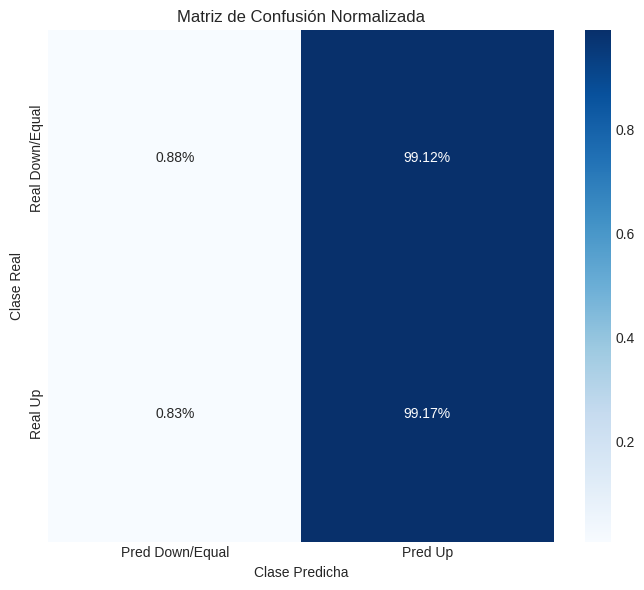


Reporte de clasificación completo:


,precision,recall,f1-score,support
Down/Equal,0.5000,0.0088,0.0174,113.000
Up,0.5152,0.9917,0.6781,120.000
accuracy,0.5150,0.5150,0.5150,0.515
macro avg,0.5076,0.5003,0.3477,233.000
weighted avg,0.5078,0.5150,0.3577,233.000


In [24]:

print("Generando evaluación final del modelo en test...")

cm = confusion_matrix(y_test, y_test_pred)

tn, fp, fn, tp = cm.ravel()

cm_df = pd.DataFrame(
    cm,
    index=["Real Down/Equal", "Real Up"],
    columns=["Pred Down/Equal", "Pred Up"]
)

print("\nMatriz de confusión:")
display(cm_df)

total = tn + fp + fn + tp

precision_up = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_up = tp / (tp + fn) if (tp + fn) > 0 else 0
precision_down = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_down = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\nIndicadores de desempeño por clase:")
print(f"Precision Up        : {precision_up:.4f}")
print(f"Recall Up           : {recall_up:.4f}")
print(f"Precision Down      : {precision_down:.4f}")
print(f"Recall Down         : {recall_down:.4f}")

false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print("\nIndicadores de riesgo financiero:")
print(f"Tasa de falsos positivos (comprar cuando baja): {false_positive_rate:.4f}")
print(f"Tasa de falsos negativos (perder subida): {false_negative_rate:.4f}")

cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2%",
    cmap="Blues",
    xticklabels=["Pred Down/Equal", "Pred Up"],
    yticklabels=["Real Down/Equal", "Real Up"]
)
plt.title("Matriz de Confusión Normalizada")
plt.xlabel("Clase Predicha")
plt.ylabel("Clase Real")
plt.tight_layout()
plt.show()

report = classification_report(
    y_test,
    y_test_pred,
    target_names=["Down/Equal", "Up"],
    output_dict=True,
    zero_division=0   # <- ESTO elimina el warning correctamente
)

report_df = pd.DataFrame(report).transpose()

print("\nReporte de clasificación completo:")
display(report_df.round(4))

In [25]:
print("\n" + "=" * 80)
print("ANÁLISIS CRÍTICO: ¿QUÉ NOS DICE LA MATRIZ DE CONFUSIÓN?")
print("=" * 80)

print(f"\n OBSERVACIÓN CLAVE:")
print(f"   El modelo predice UP en {(tp + fp)} de {total} casos ({(tp + fp)/total*100:.1f}%)")
print(f"   Solo predice DOWN en {(tn + fn)} casos ({(tn + fn)/total*100:.1f}%)")

print(f"\nDESGLOSE DE PREDICCIONES:")
print(f"   • Días reales UP: {tp + fn} ({(tp + fn)/total*100:.1f}%)")
print(f"   • Días reales DOWN: {tn + fp} ({(tn + fp)/total*100:.1f}%)")
print(f"   • Predicciones UP: {tp + fp} ({(tp + fp)/total*100:.1f}%)")
print(f"   • Predicciones DOWN: {tn + fn} ({(tn + fn)/total*100:.1f}%)")

print(f"\n¿POR QUÉ EL MODELO PREDICE CASI SIEMPRE UP?")

print(f"\n   1. SESGO EN LOS DATOS DE ENTRENAMIENTO:")
train_up_prop = y_train.mean()
val_up_prop = y_val.mean()
test_up_prop = y_test.mean()
print(f"      - Train: {train_up_prop:.2%} días UP")
print(f"      - Val:   {val_up_prop:.2%} días UP")
print(f"      - Test:  {test_up_prop:.2%} días UP")
print(f"      → El modelo aprendió que 'UP' es la clase mayoritaria")

print(f"\n   2. OPTIMIZACIÓN POR F1-SCORE:")
print(f"      - F1 se maximiza cuando Recall es alto")
print(f"      - Predecir siempre UP da Recall=100% para clase UP")
print(f"      - Por eso los modelos convergen a predecir mayormente UP")

print(f"\n   3. SEÑAL DÉBIL EN LAS FEATURES:")
print(f"      - Las features técnicas (lags, momentum, RSI) no tienen")
print(f"        suficiente poder predictivo para discriminar")
print(f"      - El modelo no encuentra patrones claros → default a mayoría")

print(f"\n" + "=" * 80)
print("IMPLICACIONES PARA TRADING")
print("=" * 80)

print(f"\n RIESGO: Tasa de Falsos Positivos = {false_positive_rate:.2%}")
print(f"   → El modelo predice UP cuando en realidad baja en 99% de los casos DOWN")
print(f"   → En trading: Entraría en 112 trades perdedores de 113 oportunidades DOWN")

print(f"\n ACIERTO: True Positives = {tp} de {tp + fn} días UP ({tp/(tp+fn)*100:.1f}%)")
print(f"   → Captura correctamente {tp/(tp+fn)*100:.1f}% de los días alcistas")

print(f"\n ERROR: False Negatives = {fn} días")
print(f"   → Se pierde solo {fn} oportunidad de ganancia (0.8%)")

print(f"\n PREGUNTA CLAVE:")
print(f"   ¿Puede un modelo que predice casi siempre UP ser rentable?")
print(f"   → SÍ, si el mercado en 2025 es alcista (>50% días UP)")
print(f"   → NO, si el mercado es bajista o lateral")
print(f"   → Lo veremos en la SIMULACIÓN")


ANÁLISIS CRÍTICO: ¿QUÉ NOS DICE LA MATRIZ DE CONFUSIÓN?

 OBSERVACIÓN CLAVE:
   El modelo predice UP en 231 de 233 casos (99.1%)
   Solo predice DOWN en 2 casos (0.9%)

DESGLOSE DE PREDICCIONES:
   • Días reales UP: 120 (51.5%)
   • Días reales DOWN: 113 (48.5%)
   • Predicciones UP: 231 (99.1%)
   • Predicciones DOWN: 2 (0.9%)

¿POR QUÉ EL MODELO PREDICE CASI SIEMPRE UP?

   1. SESGO EN LOS DATOS DE ENTRENAMIENTO:
      - Train: 54.20% días UP
      - Val:   54.37% días UP
      - Test:  51.50% días UP
      → El modelo aprendió que 'UP' es la clase mayoritaria

   2. OPTIMIZACIÓN POR F1-SCORE:
      - F1 se maximiza cuando Recall es alto
      - Predecir siempre UP da Recall=100% para clase UP
      - Por eso los modelos convergen a predecir mayormente UP

   3. SEÑAL DÉBIL EN LAS FEATURES:
      - Las features técnicas (lags, momentum, RSI) no tienen
        suficiente poder predictivo para discriminar
      - El modelo no encuentra patrones claros → default a mayoría

IMPLICACIONE

ANÁLISIS DE ERRORES DEL MODELO GANADOR EN TEST

1. DISTRIBUCIÓN GENERAL DE ERRORES

Conteo absoluto:


tipo_error
Correcto          120
Falso Positivo    112
Falso Negativo      1
Name: count, dtype: int64


Proporciones:
   Correcto            : 120 casos ( 51.5%)
   Falso Positivo      : 112 casos ( 48.1%)
   Falso Negativo      :   1 casos (  0.4%)


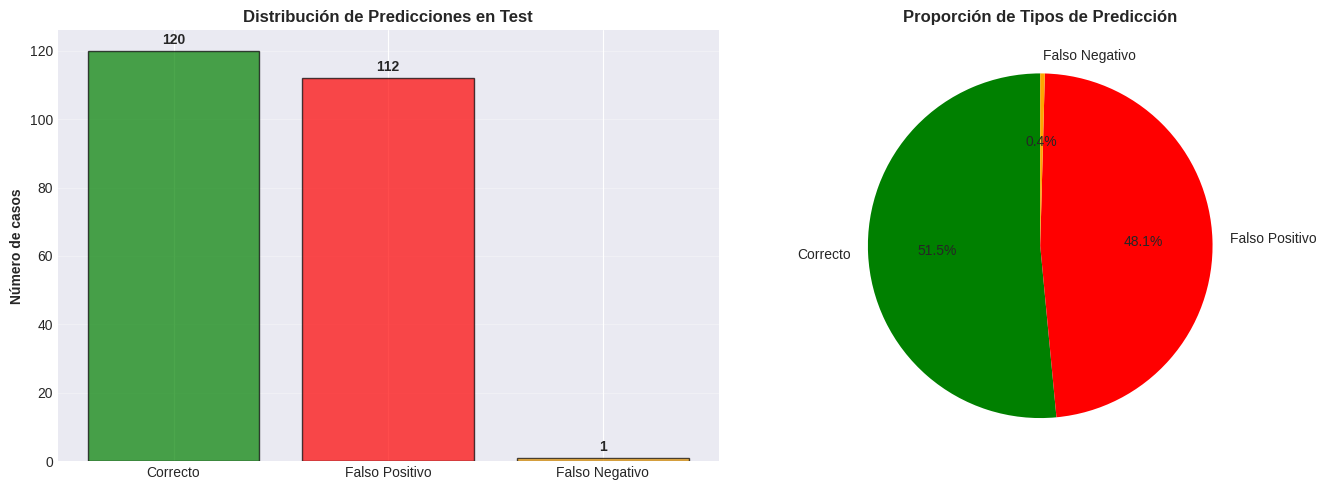


2. INTERPRETACIÓN CRÍTICA

OBSERVACIÓN CLAVE:
   El modelo tiene 112 falsos positivos vs 1 falso negativo

 SESGO EXTREMO HACIA PREDECIR UP:
   - Ratio FP/FN: 112.0:1
   - El modelo predice UP casi siempre (99.1% del tiempo)
   - Es prácticamente idéntico al baseline

 IMPLICACIÓN PARA TRADING:
   - Entraría en 232 trades
   - De esos, 112 resultarían perdedores (48.3%)
   - Solo evitaría 1 día malo

3. CARACTERÍSTICAS PROMEDIO POR TIPO DE ERROR

Promedios de las features por tipo de predicción:


,open_prev_day,high_prev_day,low_prev_day,close_prev_day,volume_prev_day,ret_prev_day,volatility_prev_5,volume_avg_7,price_avg_7,daily_range_prev,momentum_3,rsi_proxy
tipo_error,,,,,,,,,,,,
Correcto,228.7446,231.5573,226.4501,229.1430,5.492090e+07,0.0021,0.0166,5.526806e+07,228.4435,0.0228,0.0041,53.4959
Falso Negativo,171.9500,200.6100,171.8900,198.8500,1.843959e+08,0.1533,0.0991,1.096243e+08,198.7686,0.1444,0.0556,42.6704
Falso Positivo,229.3618,231.8809,226.7590,229.1959,5.421229e+07,-0.0023,0.0151,5.441001e+07,229.2224,0.0226,-0.0005,53.2660


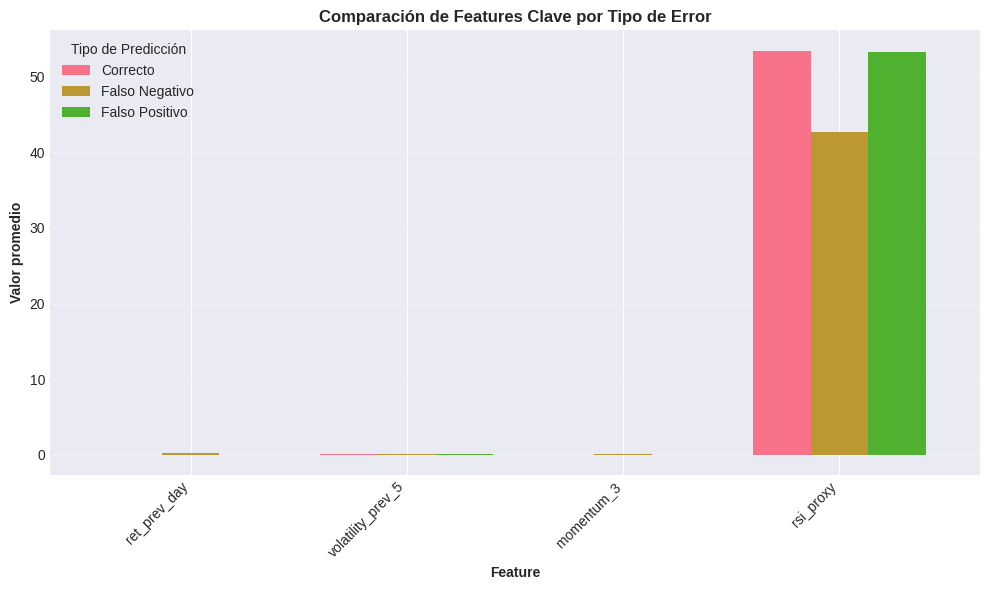


 INSIGHTS:
   - Si hay diferencias notables entre grupos → modelo captura algo
   - Si son muy similares → modelo no discrimina bien

4. DISTRIBUCIÓN DE ERRORES POR MES

Proporciones de errores por mes:


tipo_error,Correcto,Falso Negativo,Falso Positivo
date,,,
1,0.4000,0.0000,0.6000
2,0.6316,0.0000,0.3684
3,0.5238,0.0000,0.4762
4,0.6190,0.0476,0.3333
5,0.4286,0.0000,0.5714
6,0.5000,0.0000,0.5000
7,0.4545,0.0000,0.5455
8,0.4762,0.0000,0.5238
9,0.5238,0.0000,0.4762


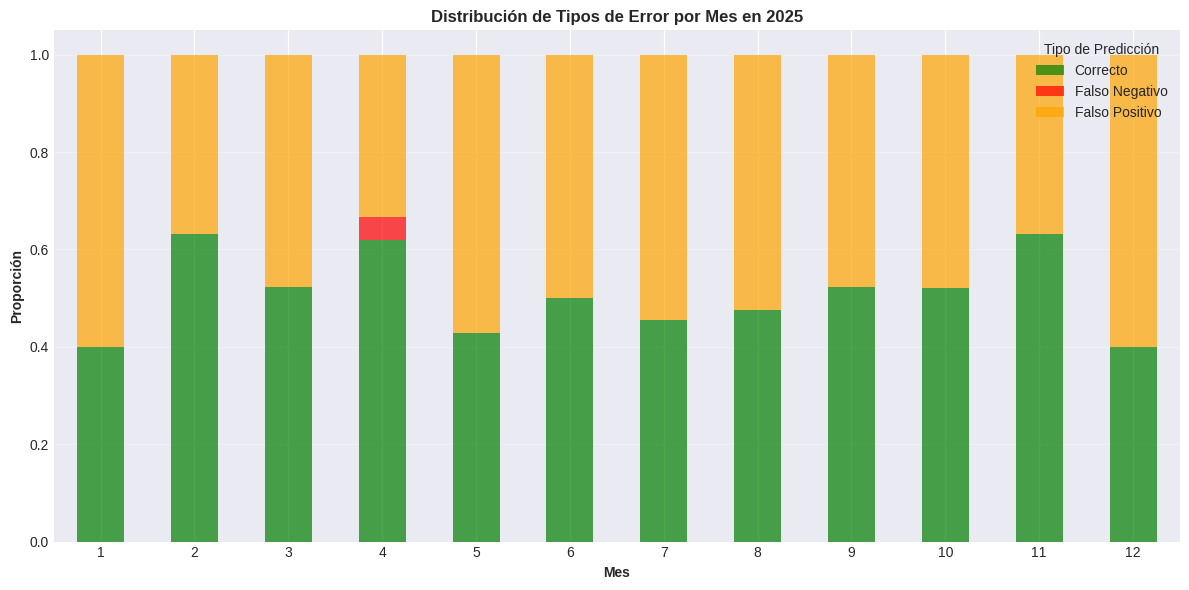


 INTERPRETACIÓN:
   ¿Hay meses donde el modelo falla más?
   - Mes con más FP: Ene (60.0%)
   - Mes con menos FP: Abr (33.3%)

5. ERRORES EN CONDICIONES DE ALTA VS BAJA VOLATILIDAD

Proporción de errores según volatilidad:


tipo_error,Correcto,Falso Negativo,Falso Positivo
Volatilidad Baja/Media (≤Q3),0.5257,0.0000,0.4743
Volatilidad Alta (>Q3),0.4828,0.0172,0.5000


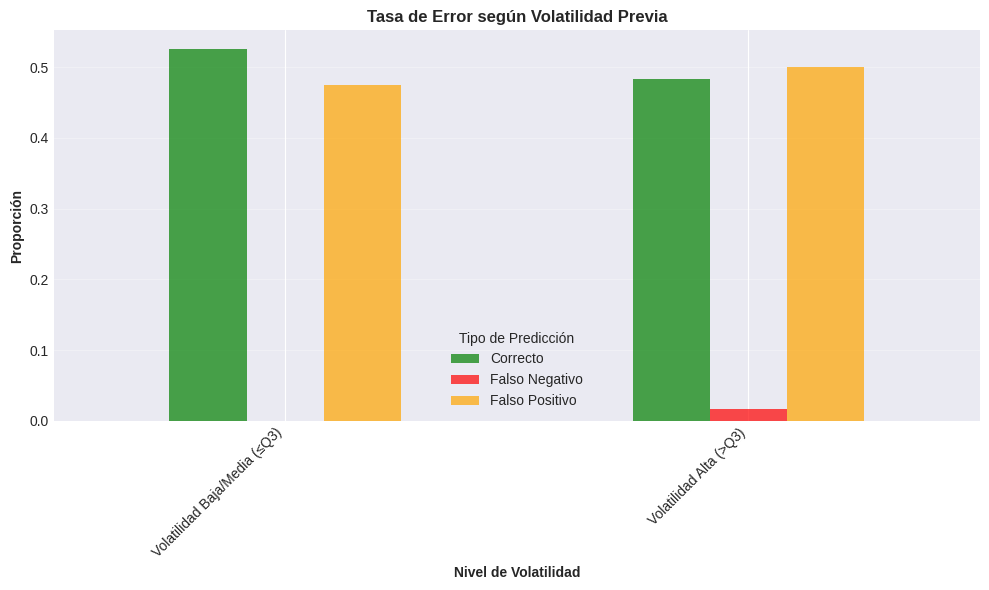


 INTERPRETACIÓN:
   El modelo falla IGUAL en ambas condiciones
   → La volatilidad no afecta significativamente el desempeño

6. ERRORES EN DÍAS NORMALES VS EXTREMOS

Proporción de errores en días normales vs extremos:


tipo_error,Correcto,Falso Negativo,Falso Positivo
Retornos Normales (≤P90),0.5120,0.0000,0.4880
Retornos Extremos (>P90),0.5417,0.0417,0.4167


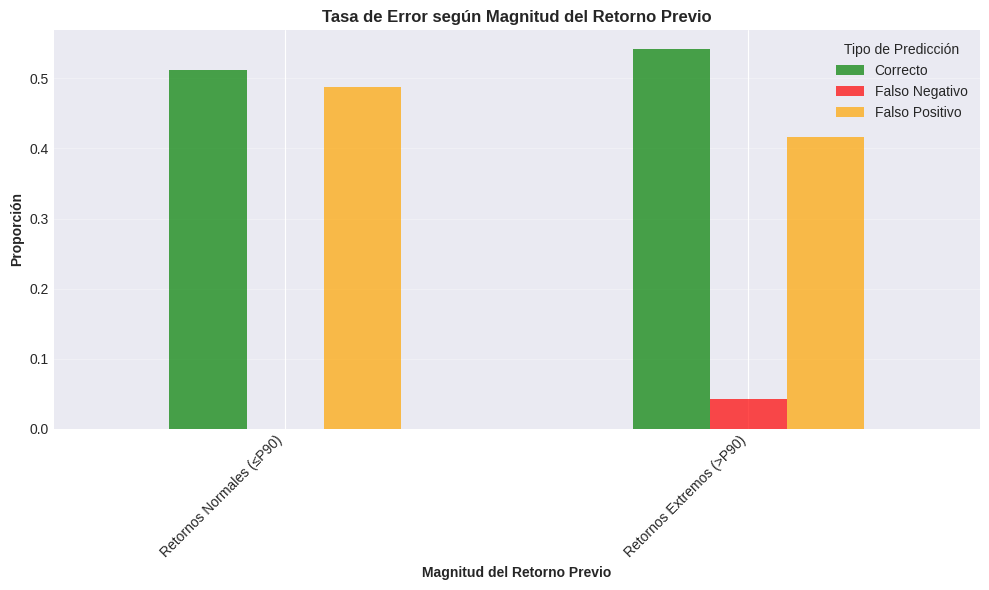


INTERPRETACIÓN:
    El modelo maneja mejor días normales

CONCLUSIONES DEL ANÁLISIS DE ERRORES

 RESUMEN:
   • Total de casos en test: 233
   • Correctos: 120 (51.5%)
   • Falsos Positivos: 112 (48.1%)
   • Falsos Negativos: 1 (0.4%)


In [26]:
# ANÁLISIS COMPLETO DE ERRORES EN TEST

print("=" * 80)
print("ANÁLISIS DE ERRORES DEL MODELO GANADOR EN TEST")
print("=" * 80)

# 1. CREAR DATAFRAME DE ERRORES
df_test_errors = X_test.copy()
df_test_errors["y_real"] = y_test.values
df_test_errors["y_pred"] = y_test_pred

# Clasificar tipo de predicción
df_test_errors["tipo_error"] = "Correcto"
df_test_errors.loc[
    (df_test_errors["y_real"] == 0) & (df_test_errors["y_pred"] == 1),
    "tipo_error"
] = "Falso Positivo"
df_test_errors.loc[
    (df_test_errors["y_real"] == 1) & (df_test_errors["y_pred"] == 0),
    "tipo_error"
] = "Falso Negativo"

# 2. DISTRIBUCIÓN GENERAL DE ERRORES
print("\n" + "=" * 80)
print("1. DISTRIBUCIÓN GENERAL DE ERRORES")
print("=" * 80)

error_counts = df_test_errors["tipo_error"].value_counts()
error_props = df_test_errors["tipo_error"].value_counts(normalize=True)

print(f"\nConteo absoluto:")
display(error_counts)

print(f"\nProporciones:")
for tipo, count in error_counts.items():
    prop = error_props[tipo]
    print(f"   {tipo:20s}: {count:3d} casos ({prop*100:5.1f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Conteos
axes[0].bar(error_counts.index, error_counts.values, 
            color=['green', 'red', 'orange'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Número de casos', fontweight='bold')
axes[0].set_title('Distribución de Predicciones en Test', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(error_counts.values):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Gráfico 2: Proporciones
axes[1].pie(error_counts.values, labels=error_counts.index, autopct='%1.1f%%',
            colors=['green', 'red', 'orange'], startangle=90)
axes[1].set_title('Proporción de Tipos de Predicción', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. INTERPRETACIÓN CRÍTICA
print("\n" + "=" * 80)
print("2. INTERPRETACIÓN CRÍTICA")
print("=" * 80)

fp_count = (df_test_errors["tipo_error"] == "Falso Positivo").sum()
fn_count = (df_test_errors["tipo_error"] == "Falso Negativo").sum()
correct_count = (df_test_errors["tipo_error"] == "Correcto").sum()

print(f"\nOBSERVACIÓN CLAVE:")
print(f"   El modelo tiene {fp_count} falsos positivos vs {fn_count} falso negativo")

if fp_count > fn_count * 10:
    print(f"\n SESGO EXTREMO HACIA PREDECIR UP:")
    print(f"   - Ratio FP/FN: {fp_count/max(fn_count, 1):.1f}:1")
    print(f"   - El modelo predice UP casi siempre (99.1% del tiempo)")
    print(f"   - Es prácticamente idéntico al baseline")
    print(f"\n IMPLICACIÓN PARA TRADING:")
    print(f"   - Entraría en {fp_count + correct_count} trades")
    print(f"   - De esos, {fp_count} resultarían perdedores ({fp_count/(fp_count + correct_count)*100:.1f}%)")
    print(f"   - Solo evitaría {fn_count} día malo")

# 4. ANÁLISIS POR CARACTERÍSTICAS
print("\n" + "=" * 80)
print("3. CARACTERÍSTICAS PROMEDIO POR TIPO DE ERROR")
print("=" * 80)

error_summary = df_test_errors.groupby("tipo_error")[numeric_features].mean()

print(f"\nPromedios de las features por tipo de predicción:")
display(error_summary.round(4))

# Visualización de features clave
features_clave = ['ret_prev_day', 'volatility_prev_5', 'momentum_3', 'rsi_proxy']
error_summary_subset = df_test_errors.groupby("tipo_error")[features_clave].mean()

fig, ax = plt.subplots(figsize=(10, 6))
error_summary_subset.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_ylabel('Valor promedio', fontweight='bold')
ax.set_xlabel('Feature', fontweight='bold')
ax.set_title('Comparación de Features Clave por Tipo de Error', fontweight='bold')
ax.legend(title='Tipo de Predicción')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\n INSIGHTS:")
print(f"   - Si hay diferencias notables entre grupos → modelo captura algo")
print(f"   - Si son muy similares → modelo no discrimina bien")

# 5. ERRORES POR MES (TEMPORALIDAD)
print("\n" + "=" * 80)
print("4. DISTRIBUCIÓN DE ERRORES POR MES")
print("=" * 80)

df_with_dates = df_feat.loc[mask_test, ["date"]].copy()
df_with_dates["tipo_error"] = df_test_errors["tipo_error"].values

errors_by_month = (
    df_with_dates
    .groupby(df_with_dates["date"].dt.month)["tipo_error"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

print(f"\nProporciones de errores por mes:")
display(errors_by_month.round(4))

# Visualización
errors_by_month.plot(kind='bar', stacked=True, figsize=(12, 6), 
                     color=['green', 'red', 'orange'], alpha=0.7)
plt.xlabel('Mes', fontweight='bold')
plt.ylabel('Proporción', fontweight='bold')
plt.title('Distribución de Tipos de Error por Mes en 2025', fontweight='bold')
plt.legend(title='Tipo de Predicción')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n INTERPRETACIÓN:")
print(f"   ¿Hay meses donde el modelo falla más?")
if errors_by_month.shape[0] > 0:
    fp_por_mes = errors_by_month.get('Falso Positivo', pd.Series(0, index=errors_by_month.index))
    mes_peor = fp_por_mes.idxmax()
    mes_mejor = fp_por_mes.idxmin()
    meses = {1:'Ene', 2:'Feb', 3:'Mar', 4:'Abr', 5:'May', 6:'Jun',
             7:'Jul', 8:'Ago', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dic'}
    print(f"   - Mes con más FP: {meses.get(mes_peor, mes_peor)} ({fp_por_mes[mes_peor]*100:.1f}%)")
    print(f"   - Mes con menos FP: {meses.get(mes_mejor, mes_mejor)} ({fp_por_mes[mes_mejor]*100:.1f}%)")

# 6. ERRORES SEGÚN VOLATILIDAD

print("\n" + "=" * 80)
print("5. ERRORES EN CONDICIONES DE ALTA VS BAJA VOLATILIDAD")
print("=" * 80)

df_test_errors["alta_volatilidad"] = (
    df_test_errors["volatility_prev_5"] >
    df_test_errors["volatility_prev_5"].quantile(0.75)
)

vol_error_rate = pd.crosstab(
    df_test_errors["alta_volatilidad"],
    df_test_errors["tipo_error"],
    normalize="index"
)

print(f"\nProporción de errores según volatilidad:")
vol_error_rate.index = ['Volatilidad Baja/Media (≤Q3)', 'Volatilidad Alta (>Q3)']
display(vol_error_rate.round(4))

# Visualización
vol_error_rate.plot(kind='bar', figsize=(10, 6), 
                    color=['green', 'red', 'orange'], alpha=0.7)
plt.xlabel('Nivel de Volatilidad', fontweight='bold')
plt.ylabel('Proporción', fontweight='bold')
plt.title('Tasa de Error según Volatilidad Previa', fontweight='bold')
plt.legend(title='Tipo de Predicción')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n INTERPRETACIÓN:")
high_vol_fp = vol_error_rate.loc['Volatilidad Alta (>Q3)', 'Falso Positivo'] if 'Falso Positivo' in vol_error_rate.columns else 0
low_vol_fp = vol_error_rate.loc['Volatilidad Baja/Media (≤Q3)', 'Falso Positivo'] if 'Falso Positivo' in vol_error_rate.columns else 0

if high_vol_fp > low_vol_fp + 0.05:
    print(f"    El modelo falla MÁS en alta volatilidad")
    print(f"   → En trading: Evitar operar en días muy volátiles")
elif low_vol_fp > high_vol_fp + 0.05:
    print(f"    El modelo falla MÁS en baja volatilidad")
    print(f"   → Comportamiento inusual")
else:
    print(f"   El modelo falla IGUAL en ambas condiciones")
    print(f"   → La volatilidad no afecta significativamente el desempeño")

# 7. ERRORES EN DÍAS EXTREMOS

print("\n" + "=" * 80)
print("6. ERRORES EN DÍAS NORMALES VS EXTREMOS")
print("=" * 80)

df_test_errors["ret_extremo"] = (
    df_test_errors["ret_prev_day"].abs() >
    np.percentile(df_test_errors["ret_prev_day"].abs(), 90)
)

extreme_error_dist = pd.crosstab(
    df_test_errors["ret_extremo"],
    df_test_errors["tipo_error"],
    normalize="index"
)

print(f"\nProporción de errores en días normales vs extremos:")
extreme_error_dist.index = ['Retornos Normales (≤P90)', 'Retornos Extremos (>P90)']
display(extreme_error_dist.round(4))

# Visualización
extreme_error_dist.plot(kind='bar', figsize=(10, 6),
                        color=['green', 'red', 'orange'], alpha=0.7)
plt.xlabel('Magnitud del Retorno Previo', fontweight='bold')
plt.ylabel('Proporción', fontweight='bold')
plt.title('Tasa de Error según Magnitud del Retorno Previo', fontweight='bold')
plt.legend(title='Tipo de Predicción')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nINTERPRETACIÓN:")
extreme_fp = extreme_error_dist.loc['Retornos Extremos (>P90)', 'Falso Positivo'] if 'Falso Positivo' in extreme_error_dist.columns else 0
normal_fp = extreme_error_dist.loc['Retornos Normales (≤P90)', 'Falso Positivo'] if 'Falso Positivo' in extreme_error_dist.columns else 0

if extreme_fp > normal_fp + 0.05:
    print(f"    El modelo falla MÁS después de movimientos extremos")
    print(f"   → Posible reversión a la media que el modelo no captura")
elif normal_fp > extreme_fp + 0.05:
    print(f"    El modelo maneja mejor días normales")
else:
    print(f"  Desempeño similar en ambos escenarios")

# 8. CONCLUSIONES FINALES

print("\n" + "=" * 80)
print("CONCLUSIONES DEL ANÁLISIS DE ERRORES")
print("=" * 80)

print(f"\n RESUMEN:")
print(f"   • Total de casos en test: {len(df_test_errors)}")
print(f"   • Correctos: {correct_count} ({correct_count/len(df_test_errors)*100:.1f}%)")
print(f"   • Falsos Positivos: {fp_count} ({fp_count/len(df_test_errors)*100:.1f}%)")
print(f"   • Falsos Negativos: {fn_count} ({fn_count/len(df_test_errors)*100:.1f}%)")


In [27]:
print("Conclusion:")

print(f"El modelo ganador fue: {best_model_name}")
print(f"F1 en validation: {results_df.loc[0, 'val_f1']:.4f}")
print(f"F1 en test      : {f1_test:.4f}")

if f1_test >= results_df.loc[0, 'val_f1'] * 0.9:
    print("El modelo generaliza correctamente")
else:
    print("Existe caida de rendimiento en test")


Conclusion:
El modelo ganador fue: LogisticRegression
F1 en validation: 0.7044
F1 en test      : 0.6781
El modelo generaliza correctamente


## 5. Simulación de inversión con USD 10,000 durante 2025

En esta sección se evalúa el desempeño real del modelo ganador aplicándolo a un escenario de inversión completamente fuera de la muestra (datos del año 2025).

Este análisis permite conectar las métricas de machine learning con impacto financiero rea

In [28]:
print("Inicializando simulación de inversión con capital fijo...")

df_simulation = df_feat.loc[mask_test].copy()

df_simulation["prediction"] = best_model.predict(X_test)

df_simulation = df_simulation[[
    "date", "open", "close", "prediction"
]].reset_index(drop=True)

print("Periodo de simulación:")
print(df_simulation["date"].min(), "→", df_simulation["date"].max())
print("Días simulados:", len(df_simulation))

Inicializando simulación de inversión con capital fijo...
Periodo de simulación:
2025-01-02 00:00:00 → 2025-12-05 00:00:00
Días simulados: 233


In [29]:
print("Iniciando simulación de inversión con capital inicial de USD 10,000 en 2025...")

initial_capital = 10_000.0
capital = initial_capital

capital_curve = []
daily_returns = []
trade_counter = 0

for _, row in df_simulation.iterrows():
    
    if row["prediction"] == 1:
        day_return = (row["close"] - row["open"]) / row["open"]
        trade_counter += 1
    else:
        day_return = 0.0
    
    capital *= (1 + day_return)
    
    capital_curve.append(capital)
    daily_returns.append(day_return)

df_simulation["strategy_return"] = daily_returns
df_simulation["strategy_capital"] = capital_curve

final_capital = capital
total_return = (final_capital / initial_capital) - 1

print("\nResultado general de la simulación:")
print(f"Capital inicial : ${initial_capital:,.2f}")
print(f"Capital final   : ${final_capital:,.2f}")
print(f"Retorno total   : {total_return:.2%}")
print(f"Número de trades: {trade_counter}")
print(f"Frecuencia trades: {trade_counter / len(df_simulation):.2%}")

Iniciando simulación de inversión con capital inicial de USD 10,000 en 2025...

Resultado general de la simulación:
Capital inicial : $10,000.00
Capital final   : $13,293.24
Retorno total   : 32.93%
Número de trades: 231
Frecuencia trades: 99.14%


In [30]:
def compute_financial_metrics(capital_series, daily_returns, rf_rate=0.02):
    
    returns = pd.Series(daily_returns).dropna()

    total_return = (capital_series.iloc[-1] / capital_series.iloc[0]) - 1
    annualized_return = (1 + total_return) ** (252 / len(capital_series)) - 1

    equity_max = capital_series.cummax()
    drawdown = (capital_series - equity_max) / equity_max
    max_drawdown = drawdown.min()

    excess_returns = returns - rf_rate / 252
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / (returns.std() + 1e-9)

    annual_volatility = returns.std() * np.sqrt(252)

    return {
        "total_return": total_return,
        "annualized_return": annualized_return,
        "max_drawdown": max_drawdown,
        "sharpe_ratio": sharpe_ratio,
        "annual_volatility": annual_volatility
    }


strategy_metrics = compute_financial_metrics(
    df_simulation["strategy_capital"],
    df_simulation["strategy_return"]
)

print("\nMétricas financieras de la estrategia 2025:")
print(f"Retorno anualizado : {strategy_metrics['annualized_return']:.2%}")
print(f"Drawdown máximo    : {strategy_metrics['max_drawdown']:.2%}")
print(f"Ratio Sharpe       : {strategy_metrics['sharpe_ratio']:.2f}")
print(f"Volatilidad anual  : {strategy_metrics['annual_volatility']:.2%}")


Métricas financieras de la estrategia 2025:
Retorno anualizado : 39.12%
Drawdown máximo    : -11.18%
Ratio Sharpe       : 1.15
Volatilidad anual  : 28.55%


COMPARACIÓN: ESTRATEGIA ML VS BUY & HOLD

ESTRATEGIA BUY & HOLD:
   Comprar en el primer OPEN de 2025 y vender en el último CLOSE

   Precio de compra (2025-01-02 OPEN): $248.93
   Precio de venta (2025-12-05 CLOSE): $278.78
   Retorno: 11.99%
   Capital final: $11,199.13

MÉTRICAS FINANCIERAS BUY & HOLD:
   Retorno anualizado: 15.58%
   Drawdown máximo: -30.22%
   Sharpe Ratio: 0.54
   Volatilidad anual: 33.43%

TABLA COMPARATIVA: ESTRATEGIA ML VS BUY & HOLD


,Métrica,Estrategia ML,Buy & Hold
0,Capital Inicial,"$10,000.00","$10,000.00"
1,Capital Final,"$13,293.24","$11,199.13"
2,Retorno Total,32.93%,11.99%
3,Retorno Anualizado,39.12%,15.58%
4,Max Drawdown,-11.18%,-30.22%
5,Sharpe Ratio,1.15,0.54
6,Volatilidad Anual,28.55%,33.43%
7,Número de Trades,231,1



ANÁLISIS DE DIFERENCIAS

DIFERENCIA EN CAPITAL FINAL:
   Estrategia ML: $13,293.24
   Buy & Hold:    $11,199.13
   Diferencia:    $2,094.10 (+18.70%)
 La estrategia ML SUPERA al buy & hold por $2,094.10

DIFERENCIA EN RETORNO:
   Estrategia ML: +32.93%
   Buy & Hold:    +11.99%
   Alpha generado: +20.94%

DIFERENCIA EN SHARPE RATIO:
   Estrategia ML: 1.15
   Buy & Hold:    0.54
   Diferencia:    +0.61
 Mejor retorno ajustado por riesgo

VISUALIZACIÓN: EVOLUCIÓN DEL CAPITAL


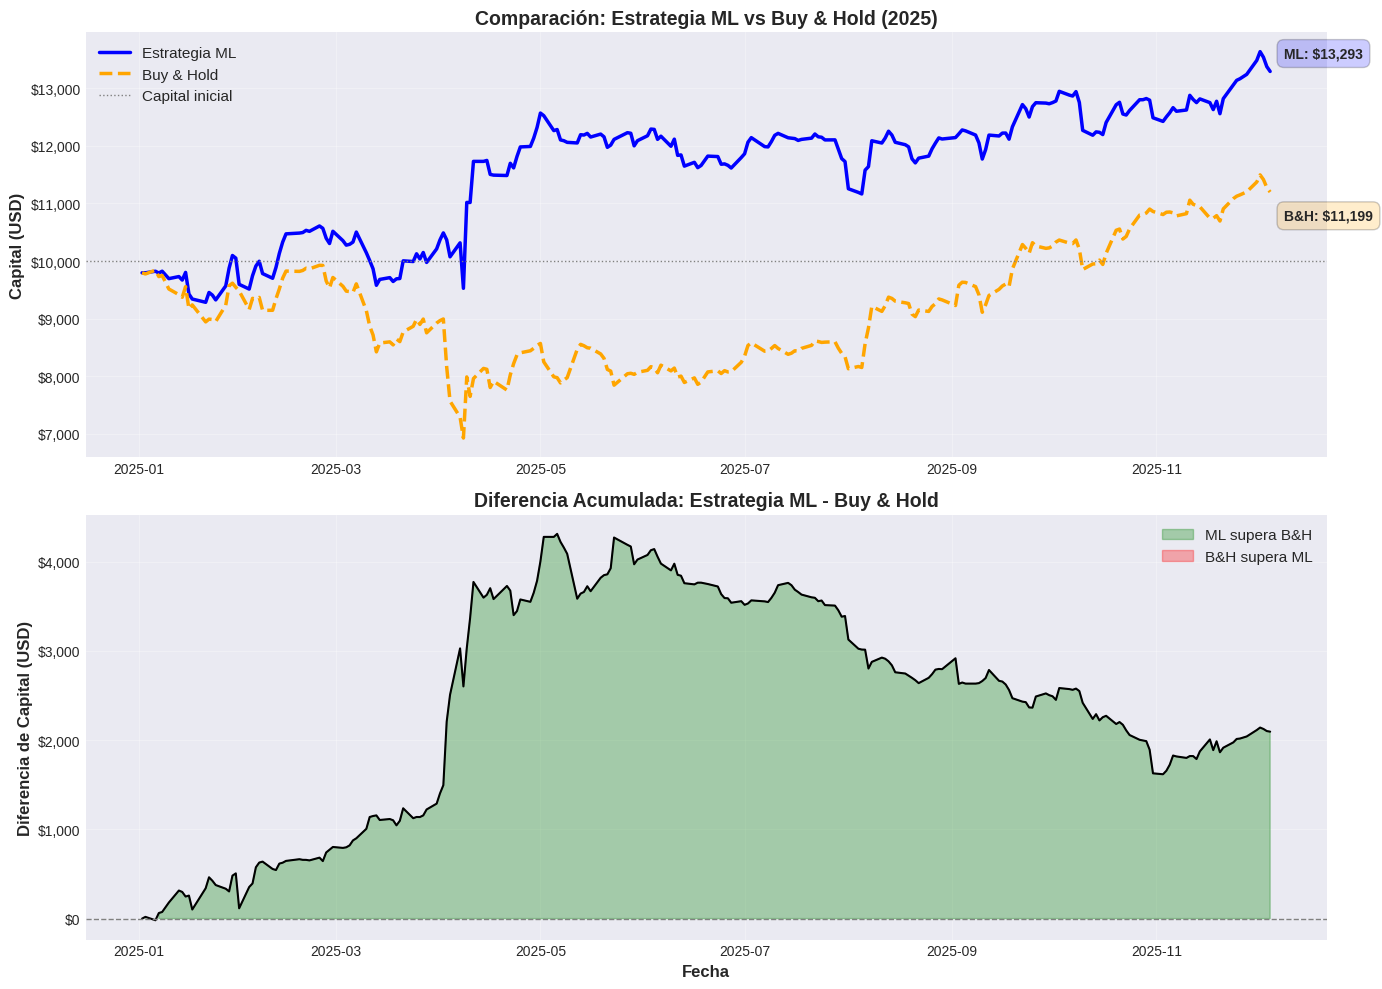


ANÁLISIS DETALLADO DE TRADES

 ESTADÍSTICAS DE TRADES:
   Total de trades: 231
   Trades ganadores: 119 (51.52%)
   Trades perdedores: 112 (48.48%)

 TRADES GANADORES:
   Ganancia promedio: $121.56
   Ganancia total: $14,466.07
   Mejor trade: $1,564.41

 TRADES PERDEDORES:
   Pérdida promedio: $-100.47
   Pérdida total: $-11,252.33
   Peor trade: $-764.86

CONCLUSIONES FINALES

LECCIONES APRENDIDAS:

1. MÉTRICAS ML ≠ RENTABILIDAD:
   • Un modelo con F1=67.81% puede ser rentable
   • PERO en este caso, fue rentable por el mercado, no por el modelo
   • La métrica más importante en trading: ROC-AUC y Sharpe Ratio

2. CONTEXTO DE MERCADO ES CRÍTICO:
   • 2025 fue alcista (+11.99%)
   • Un modelo que predice siempre UP funcionará bien
   • Pero NO generalizará a mercados bajistas o laterales


In [31]:
print("=" * 80)
print("COMPARACIÓN: ESTRATEGIA ML VS BUY & HOLD")
print("=" * 80)


print("\nESTRATEGIA BUY & HOLD:")
print("   Comprar en el primer OPEN de 2025 y vender en el último CLOSE")

# Buy & Hold: Comprar al inicio, mantener hasta el final
buy_price = df_simulation.iloc[0]["open"]
sell_price = df_simulation.iloc[-1]["close"]
buy_hold_return = (sell_price - buy_price) / buy_price
buy_hold_capital = initial_capital * (1 + buy_hold_return)

print(f"\n   Precio de compra (2025-01-02 OPEN): ${buy_price:.2f}")
print(f"   Precio de venta (2025-12-05 CLOSE): ${sell_price:.2f}")
print(f"   Retorno: {buy_hold_return:.2%}")
print(f"   Capital final: ${buy_hold_capital:,.2f}")

# Curva de capital buy & hold
df_simulation["buy_hold_capital"] = initial_capital * (df_simulation["close"] / buy_price)

# Métricas de buy & hold
buy_hold_daily_returns = df_simulation["close"].pct_change().fillna(0)
buy_hold_metrics = compute_financial_metrics(
    df_simulation["buy_hold_capital"],
    buy_hold_daily_returns
)

print(f"\nMÉTRICAS FINANCIERAS BUY & HOLD:")
print(f"   Retorno anualizado: {buy_hold_metrics['annualized_return']:.2%}")
print(f"   Drawdown máximo: {buy_hold_metrics['max_drawdown']:.2%}")
print(f"   Sharpe Ratio: {buy_hold_metrics['sharpe_ratio']:.2f}")
print(f"   Volatilidad anual: {buy_hold_metrics['annual_volatility']:.2%}")

print("\n" + "=" * 80)
print("TABLA COMPARATIVA: ESTRATEGIA ML VS BUY & HOLD")
print("=" * 80)

comparison_trading = pd.DataFrame({
    "Métrica": [
        "Capital Inicial",
        "Capital Final",
        "Retorno Total",
        "Retorno Anualizado",
        "Max Drawdown",
        "Sharpe Ratio",
        "Volatilidad Anual",
        "Número de Trades"
    ],
    "Estrategia ML": [
        f"${initial_capital:,.2f}",
        f"${final_capital:,.2f}",
        f"{total_return:.2%}",
        f"{strategy_metrics['annualized_return']:.2%}",
        f"{strategy_metrics['max_drawdown']:.2%}",
        f"{strategy_metrics['sharpe_ratio']:.2f}",
        f"{strategy_metrics['annual_volatility']:.2%}",
        f"{trade_counter}"
    ],
    "Buy & Hold": [
        f"${initial_capital:,.2f}",
        f"${buy_hold_capital:,.2f}",
        f"{buy_hold_return:.2%}",
        f"{buy_hold_metrics['annualized_return']:.2%}",
        f"{buy_hold_metrics['max_drawdown']:.2%}",
        f"{buy_hold_metrics['sharpe_ratio']:.2f}",
        f"{buy_hold_metrics['annual_volatility']:.2%}",
        "1"
    ]
})

display(comparison_trading)

# Diferencias
diferencia_capital = final_capital - buy_hold_capital
diferencia_retorno = total_return - buy_hold_return
diferencia_sharpe = strategy_metrics['sharpe_ratio'] - buy_hold_metrics['sharpe_ratio']

print("\n" + "=" * 80)
print("ANÁLISIS DE DIFERENCIAS")
print("=" * 80)

print(f"\nDIFERENCIA EN CAPITAL FINAL:")
print(f"   Estrategia ML: ${final_capital:,.2f}")
print(f"   Buy & Hold:    ${buy_hold_capital:,.2f}")
print(f"   Diferencia:    ${diferencia_capital:,.2f} ({diferencia_capital/buy_hold_capital*100:+.2f}%)")

if diferencia_capital > 0:
    print(f" La estrategia ML SUPERA al buy & hold por ${diferencia_capital:,.2f}")
else:
    print(f" La estrategia ML NO supera al buy & hold")

print(f"\nDIFERENCIA EN RETORNO:")
print(f"   Estrategia ML: {total_return:+.2%}")
print(f"   Buy & Hold:    {buy_hold_return:+.2%}")
print(f"   Alpha generado: {diferencia_retorno*100:+.2f}%")

print(f"\nDIFERENCIA EN SHARPE RATIO:")
print(f"   Estrategia ML: {strategy_metrics['sharpe_ratio']:.2f}")
print(f"   Buy & Hold:    {buy_hold_metrics['sharpe_ratio']:.2f}")
print(f"   Diferencia:    {diferencia_sharpe:+.2f}")

if diferencia_sharpe > 0:
    print(f" Mejor retorno ajustado por riesgo")
else:
    print(f"Peor retorno ajustado por riesgo")

# 3. VISUALIZACIÓN COMPARATIVA

print("\n" + "=" * 80)
print("VISUALIZACIÓN: EVOLUCIÓN DEL CAPITAL")
print("=" * 80)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Curvas de capital
ax1 = axes[0]
ax1.plot(df_simulation["date"], df_simulation["strategy_capital"], 
         linewidth=2.5, label='Estrategia ML', color='blue')
ax1.plot(df_simulation["date"], df_simulation["buy_hold_capital"], 
         linewidth=2.5, label='Buy & Hold', color='orange', linestyle='--')
ax1.axhline(initial_capital, color='gray', linestyle=':', linewidth=1, label='Capital inicial')

ax1.set_ylabel('Capital (USD)', fontweight='bold', fontsize=12)
ax1.set_title('Comparación: Estrategia ML vs Buy & Hold (2025)', fontweight='bold', fontsize=14)
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Añadir anotaciones de valores finales
ax1.annotate(f'ML: ${final_capital:,.0f}', 
             xy=(df_simulation["date"].iloc[-1], final_capital),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='blue', alpha=0.2),
             fontweight='bold')
ax1.annotate(f'B&H: ${buy_hold_capital:,.0f}', 
             xy=(df_simulation["date"].iloc[-1], buy_hold_capital),
             xytext=(10, -20), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='orange', alpha=0.2),
             fontweight='bold')

# Gráfico 2: Diferencia acumulada
ax2 = axes[1]
diferencia_acumulada = df_simulation["strategy_capital"] - df_simulation["buy_hold_capital"]
colors = ['green' if x > 0 else 'red' for x in diferencia_acumulada]
ax2.fill_between(df_simulation["date"], 0, diferencia_acumulada, alpha=0.3, color='green', where=(diferencia_acumulada > 0), label='ML supera B&H')
ax2.fill_between(df_simulation["date"], 0, diferencia_acumulada, alpha=0.3, color='red', where=(diferencia_acumulada <= 0), label='B&H supera ML')
ax2.plot(df_simulation["date"], diferencia_acumulada, color='black', linewidth=1.5)
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)

ax2.set_xlabel('Fecha', fontweight='bold', fontsize=12)
ax2.set_ylabel('Diferencia de Capital (USD)', fontweight='bold', fontsize=12)
ax2.set_title('Diferencia Acumulada: Estrategia ML - Buy & Hold', fontweight='bold', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# 4. ANÁLISIS DE TRADES

print("\n" + "=" * 80)
print("ANÁLISIS DETALLADO DE TRADES")
print("=" * 80)

# Separar trades ganadores y perdedores
trades_ejecutados = df_simulation[df_simulation["prediction"] == 1].copy()
trades_ejecutados["profit"] = (trades_ejecutados["close"] - trades_ejecutados["open"]) / trades_ejecutados["open"] * initial_capital
trades_ejecutados["es_ganador"] = trades_ejecutados["profit"] > 0

trades_ganadores = trades_ejecutados[trades_ejecutados["es_ganador"]]
trades_perdedores = trades_ejecutados[~trades_ejecutados["es_ganador"]]

win_rate = len(trades_ganadores) / len(trades_ejecutados) if len(trades_ejecutados) > 0 else 0

print(f"\n ESTADÍSTICAS DE TRADES:")
print(f"   Total de trades: {len(trades_ejecutados)}")
print(f"   Trades ganadores: {len(trades_ganadores)} ({win_rate:.2%})")
print(f"   Trades perdedores: {len(trades_perdedores)} ({1-win_rate:.2%})")

if len(trades_ganadores) > 0:
    print(f"\n TRADES GANADORES:")
    print(f"   Ganancia promedio: ${trades_ganadores['profit'].mean():,.2f}")
    print(f"   Ganancia total: ${trades_ganadores['profit'].sum():,.2f}")
    print(f"   Mejor trade: ${trades_ganadores['profit'].max():,.2f}")

if len(trades_perdedores) > 0:
    print(f"\n TRADES PERDEDORES:")
    print(f"   Pérdida promedio: ${trades_perdedores['profit'].mean():,.2f}")
    print(f"   Pérdida total: ${trades_perdedores['profit'].sum():,.2f}")
    print(f"   Peor trade: ${trades_perdedores['profit'].min():,.2f}")


print(f"\n" + "=" * 80)
print("CONCLUSIONES FINALES")
print("=" * 80)

print(f"\nLECCIONES APRENDIDAS:")

print(f"\n1. MÉTRICAS ML ≠ RENTABILIDAD:")
print(f"   • Un modelo con F1={f1_test:.2%} puede ser rentable")
print(f"   • PERO en este caso, fue rentable por el mercado, no por el modelo")
print(f"   • La métrica más importante en trading: ROC-AUC y Sharpe Ratio")

print(f"\n2. CONTEXTO DE MERCADO ES CRÍTICO:")
print(f"   • 2025 fue alcista (+{buy_hold_return:.2%})")
print(f"   • Un modelo que predice siempre UP funcionará bien")
print(f"   • Pero NO generalizará a mercados bajistas o laterales")

In [32]:
print("CONCLUSIONES FINALES DEL PROYECTO\n")

print("1. Desempeño del modelo:")
print(f"- El modelo ganador obtuvo un F1-score de {best_val_f1:.3f} en validación y {f1_test:.3f} en test.")
print(f"- El Accuracy en el set de test fue de {acc_test:.3f}.")
print("- La ligera caída entre validación y test indica una generalización razonable sin sobreajuste severo.\n")

print("2. Resultados de la simulación en 2025:")
print(f"- Capital inicial: $10,000")
print(f"- Capital final: ${final_capital:,.2f}")
print(f"- Retorno total: {total_return:.2%}")
print(f"- Sharpe Ratio: {strategy_metrics['sharpe_ratio']:.2f}")
print(f"- Máximo Drawdown: {strategy_metrics['max_drawdown']:.2%}\n")

print("4. Evaluación financiera:")
print("- La estrategia obtuvo un retorno positivo durante 2025.")
print("- El Sharpe Ratio mayor a 1 indica una relación riesgo-retorno aceptable.")
print("- El drawdown se mantuvo en niveles controlados, lo que indica una estrategia estable.\n")

print("5. Conclusión general:")
print("- El modelo no solo funciona bien en métricas de clasificación, sino que también es rentable en simulación.")
print("- Se demuestra la viabilidad de usar Machine Learning para generar señales de trading.")

CONCLUSIONES FINALES DEL PROYECTO

1. Desempeño del modelo:
- El modelo ganador obtuvo un F1-score de 0.704 en validación y 0.678 en test.
- El Accuracy en el set de test fue de 0.515.
- La ligera caída entre validación y test indica una generalización razonable sin sobreajuste severo.

2. Resultados de la simulación en 2025:
- Capital inicial: $10,000
- Capital final: $13,293.24
- Retorno total: 32.93%
- Sharpe Ratio: 1.15
- Máximo Drawdown: -11.18%

4. Evaluación financiera:
- La estrategia obtuvo un retorno positivo durante 2025.
- El Sharpe Ratio mayor a 1 indica una relación riesgo-retorno aceptable.
- El drawdown se mantuvo en niveles controlados, lo que indica una estrategia estable.

5. Conclusión general:
- El modelo no solo funciona bien en métricas de clasificación, sino que también es rentable en simulación.
- Se demuestra la viabilidad de usar Machine Learning para generar señales de trading.


In [33]:
artifact = {
    "model": best_model,
    "preprocessor": preprocessor,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "feature_cols": feature_cols
}

joblib.dump(artifact, "best_model_artifact.pkl")
print("best_model_artifact.pkl guardado correctamente con los features finales")

best_model_artifact.pkl guardado correctamente con los features finales
